In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import missingno as msno
from sklearn.metrics import accuracy_score, jaccard_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler, OrdinalEncoder
import warnings

In [2]:
# Pandas Veri Çerçevesi

warnings.filterwarnings("ignore", category=FutureWarning) # Removes the warning about features that may become dysfunctional or change in future versions.

warnings.filterwarnings("ignore", category=FutureWarning, message="use_inf_as_na option is deprecated") # To ignore the "use_inf_as_na option is deprecated" warning.

pd.set_option('display.max_columns', None) # It makes the maximum number of views of columns in the DataFrame unlimited.

pd.set_option('display.float_format', lambda x: '%.3f' % x) # Enables decimal numbers to be displayed with three decimal places by default.

pd.set_option('display.width', 500) # Sets the maximum width of characters that can be displayed on a line to 500.

pd.set_option('display.max_rows', None) # Makes the maximum number of numbers in the DataFrame unlimited.

In [3]:
# 3 separate functions that enable reading data sets.

def load_df():
    df = pd.read_parquet("train_final.parquet")
    return df

def load_df_test():
    df_test = pd.read_parquet("test_final.parquet")
    return df_test

def load_df_submission_sample():
    df_submission_sample = pd.read_parquet("submission_sample_final.parquet")
    return df_submission_sample

In [4]:
df = load_df()

In [5]:
# Enlarges column names.

df.columns = [col.upper() for col in df.columns]

In [6]:
# A function that allows us to take a first look at the data.

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    
    print("##################### Types #####################")
    print(dataframe.dtypes)
    
    print("##################### Head #####################")
    print(dataframe.head())
    
    print("##################### Tail #####################")
    print(dataframe.tail())
    
    print("##################### NA #####################")
    print(dataframe.isnull().sum())

    print("##################### Describe #####################")
    print(dataframe.describe().T)
    
    print("##################### Quantiles #####################")
    keep_columns = [col for col in dataframe.columns if dataframe[col].dtype in ['int64', 'float64']]
    df_numeric = dataframe[keep_columns]
    print(df_numeric.quantile([0, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99, 1]).T)

In [ ]:
check_df(df)

In [7]:
# To check the number of unique values and data types of variables.

for col in df.columns:
    print(f'{col}: {df[col].nunique()} ({df[col].dtype}) ')
    print('-------------------------------------------------------------')

ID: 80478 (object) 
-------------------------------------------------------------
MONTH: 3 (int64) 
-------------------------------------------------------------
N_SECONDS_1: 88738 (float64) 
-------------------------------------------------------------
N_SECONDS_2: 82245 (float64) 
-------------------------------------------------------------
N_SECONDS_3: 67633 (float64) 
-------------------------------------------------------------
CARRIER: 556 (object) 
-------------------------------------------------------------
DEVICEBRAND: 64 (object) 
-------------------------------------------------------------
FEATURE_0: 94049 (float64) 
-------------------------------------------------------------
FEATURE_1: 94049 (float64) 
-------------------------------------------------------------
FEATURE_2: 94049 (float64) 
-------------------------------------------------------------
FEATURE_3: 94049 (float64) 
-------------------------------------------------------------
FEATURE_4: 94049 (float64) 
-

# DEVICEBRAND

In [ ]:
df['DEVICEBRAND'].unique()

In [8]:
df['DEVICEBRAND'] = df['DEVICEBRAND'].str.lower() # Converts the observations in the relevant column to lowercase.

In [9]:
df['DEVICEBRAND'] = df['DEVICEBRAND'].str.capitalize() # Capitalizes the first letters of the observations in the relevant column.

In [10]:
df['DEVICEBRAND'] = df['DEVICEBRAND'].apply(lambda x: 'Redmi' if 'Xiaomi' in x else x) # Changes observations from Xiaomi to Redmi.

In [11]:
df['DEVICEBRAND'] = df['DEVICEBRAND'].apply(lambda x: 'Gm' if 'Generalmobile' in x else x) # Changes observations from General Mobile to Gm.

# CARRIER

In [12]:
df['CARRIER'].nunique()

556

In [13]:
# Changes each value containing VODAFONE in the observation in the relevant column to VODAFONE.
df['CARRIER'] = df['CARRIER'].apply(lambda x: 'VODAFONE' if 'VODAFONE' in x else x)

In [14]:
# Changes each value containing HAYATEVESIGAR in the observation in the relevant column to VODAFONE.
df['CARRIER'] = df['CARRIER'].apply(lambda x: 'VODAFONE' if 'HAYATEVESIGAR' in x else x)

In [15]:
# Changes each value containing TURKCELL in the observation in the relevant column to TURKCELL.
df['CARRIER'] = df['CARRIER'].apply(lambda x: 'TURKCELL' if 'TURKCELL' in x else x)

In [16]:
# Changes each value containing EVDEHAYATVAR in the observation in the relevant column to TURKCELL.
df['CARRIER'] = df['CARRIER'].apply(lambda x: 'TURKCELL' if 'EVDEHAYATVAR' in x else x)

In [17]:
# Changes each value containing TURK TELEKOM in the observation in the relevant column to TURK TELEKOM.
df['CARRIER'] = df['CARRIER'].apply(lambda x: 'TURK TELEKOM' if 'TURK TELEKOM' in x else x)

In [18]:
# Changes each value containing AVEA in the observation in the relevant column to TURK TELEKOM.
df['CARRIER'] = df['CARRIER'].apply(lambda x: 'TURK TELEKOM' if 'AVEA' in x else x)

In [19]:
# Changes each value containing EVDEKAL in the observation in the relevant column to TURK TELEKOM.
df['CARRIER'] = df['CARRIER'].apply(lambda x: 'TURK TELEKOM' if 'EVDEKAL' in x else x)

In [20]:
# Changes each value containing TEKNOSA in the observation in the relevant column to TEKNOSA.
df['CARRIER'] = df['CARRIER'].apply(lambda x: 'TEKNOSA' if 'TEKNOSA' in x else x)

In [21]:
df['CARRIER'].nunique()

503

# VARIABLE SELECTION

In [22]:
def grab_col_names(dataframe, cat_th = 10, car_th = 20):
    
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == 'O']
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtype != 'O']
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtype == 'O']
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    
    #num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtype != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")
    
    return cat_cols, num_cols, cat_but_car

In [23]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 94049
Variables: 58
cat_cols: 1
num_cols: 53
cat_but_car: 4
num_but_cat: 1


# ID

In [24]:
df.head()

,ID,MONTH,N_SECONDS_1,N_SECONDS_2,N_SECONDS_3,CARRIER,DEVICEBRAND,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,FEATURE_12,FEATURE_13,FEATURE_14,FEATURE_15,FEATURE_16,FEATURE_17,FEATURE_18,FEATURE_19,FEATURE_20,FEATURE_21,FEATURE_22,FEATURE_23,FEATURE_24,FEATURE_25,FEATURE_26,FEATURE_27,FEATURE_28,FEATURE_29,FEATURE_30,FEATURE_31,FEATURE_32,FEATURE_33,FEATURE_34,FEATURE_35,FEATURE_36,FEATURE_37,FEATURE_38,FEATURE_39,FEATURE_40,FEATURE_41,FEATURE_42,FEATURE_43,FEATURE_44,FEATURE_45,FEATURE_46,FEATURE_47,FEATURE_48,FEATURE_49,TARGET
0,5beefd4d2bf4a4767e0df8108,10,5245.571,981.182,205.948,VODAFONE,Apple,-1.198,1.113,-1.123,-0.264,2.161,2.651,0.810,1.516,2.351,-4.608,0.678,-0.555,3.502,-0.765,1.543,-1.458,-1.017,-1.820,0.726,-1.444,1.087,2.102,-0.249,-0.583,-1.330,1.407,1.054,-1.532,1.667,0.251,-0.091,2.676,-0.621,0.163,1.720,-6.139,-0.303,2.784,-3.135,-3.794,0.930,-2.613,-2.033,2.646,-1.023,1.659,-1.559,-2.161,30,58,"menu2, menu4, menu5"
1,867285b116c063d5a8482f5be,10,5184.876,557.650,487.587,TURKCELL,Samsung,-2.336,2.568,-0.495,0.949,3.568,3.358,0.434,0.886,1.452,-3.184,1.024,1.166,2.916,-1.281,3.019,-3.163,-1.120,-2.798,0.287,-2.029,0.260,0.962,-0.534,-1.311,-0.144,-1.562,1.931,-0.942,-0.000,-1.372,1.225,2.795,-0.961,0.114,1.048,-5.697,0.902,-0.073,-2.366,-0.600,0.815,-0.984,-1.454,-0.022,-0.196,2.776,-0.319,-4.291,21,45,"menu7, menu8, menu4"
2,c82a7cbd2e00d9b66c06bcadc,10,3835.618,3275.128,43.806,TURK TELEKOM,Redmi,-2.561,2.062,-0.185,1.062,4.198,1.551,-0.596,-0.619,2.017,-4.631,-0.663,-0.838,1.821,-2.171,3.695,-0.922,-2.873,-2.042,0.533,-0.128,0.450,2.716,-0.178,0.052,-0.518,-0.043,1.157,-0.527,-0.088,-0.497,1.203,2.742,-0.623,1.757,2.059,-5.359,0.929,1.133,-3.100,-1.253,1.057,-1.669,-3.599,1.674,0.632,1.293,-2.231,-2.384,19,61,"menu2, menu8, menu4"
3,f2d2b25073ccc298eced86897,10,3532.544,154.509,64.724,TURKCELL,Samsung,-2.530,3.358,-0.851,1.644,2.849,3.887,1.855,0.988,2.066,-5.804,1.931,0.151,3.145,-2.673,0.378,-2.657,-0.378,-3.276,0.003,-0.674,-0.227,1.817,0.068,-0.787,-1.708,-2.000,1.770,0.049,0.230,-0.304,1.659,1.692,-1.105,1.242,2.043,-3.854,0.649,0.944,-3.027,-1.824,0.204,-1.861,-1.220,1.863,0.213,1.030,-1.142,-4.466,2,41,"menu6, menu2, menu1"
4,7818c92a58af0f2cb7c361738,10,3344.192,787.896,715.115,VODAFONE,Samsung,-2.922,2.096,0.061,-1.488,3.225,2.092,-0.993,0.686,2.090,-2.974,-0.797,-1.459,2.398,-1.308,3.381,-2.664,-2.219,-1.714,1.288,-2.250,2.345,0.403,-0.077,0.289,1.847,1.424,1.888,-1.022,1.021,-0.843,-0.859,2.565,0.412,0.068,0.391,-5.996,2.675,0.203,-3.272,-1.418,2.188,-0.143,-1.876,1.024,-0.186,-0.062,-1.462,-2.371,23,85,"menu6, menu2, menu8"


In [25]:
# Frequency of IDs


id_to_freq = df['ID'].value_counts()

In [26]:
# Saving frequencies as a dictionary

id_to_freq = id_to_freq.to_dict()

In [27]:
df['ID_FREQ'] = df['ID'].map(id_to_freq)

In [28]:
df.head()

,ID,MONTH,N_SECONDS_1,N_SECONDS_2,N_SECONDS_3,CARRIER,DEVICEBRAND,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,FEATURE_12,FEATURE_13,FEATURE_14,FEATURE_15,FEATURE_16,FEATURE_17,FEATURE_18,FEATURE_19,FEATURE_20,FEATURE_21,FEATURE_22,FEATURE_23,FEATURE_24,FEATURE_25,FEATURE_26,FEATURE_27,FEATURE_28,FEATURE_29,FEATURE_30,FEATURE_31,FEATURE_32,FEATURE_33,FEATURE_34,FEATURE_35,FEATURE_36,FEATURE_37,FEATURE_38,FEATURE_39,FEATURE_40,FEATURE_41,FEATURE_42,FEATURE_43,FEATURE_44,FEATURE_45,FEATURE_46,FEATURE_47,FEATURE_48,FEATURE_49,TARGET,ID_FREQ
0,5beefd4d2bf4a4767e0df8108,10,5245.571,981.182,205.948,VODAFONE,Apple,-1.198,1.113,-1.123,-0.264,2.161,2.651,0.810,1.516,2.351,-4.608,0.678,-0.555,3.502,-0.765,1.543,-1.458,-1.017,-1.820,0.726,-1.444,1.087,2.102,-0.249,-0.583,-1.330,1.407,1.054,-1.532,1.667,0.251,-0.091,2.676,-0.621,0.163,1.720,-6.139,-0.303,2.784,-3.135,-3.794,0.930,-2.613,-2.033,2.646,-1.023,1.659,-1.559,-2.161,30,58,"menu2, menu4, menu5",1
1,867285b116c063d5a8482f5be,10,5184.876,557.650,487.587,TURKCELL,Samsung,-2.336,2.568,-0.495,0.949,3.568,3.358,0.434,0.886,1.452,-3.184,1.024,1.166,2.916,-1.281,3.019,-3.163,-1.120,-2.798,0.287,-2.029,0.260,0.962,-0.534,-1.311,-0.144,-1.562,1.931,-0.942,-0.000,-1.372,1.225,2.795,-0.961,0.114,1.048,-5.697,0.902,-0.073,-2.366,-0.600,0.815,-0.984,-1.454,-0.022,-0.196,2.776,-0.319,-4.291,21,45,"menu7, menu8, menu4",1
2,c82a7cbd2e00d9b66c06bcadc,10,3835.618,3275.128,43.806,TURK TELEKOM,Redmi,-2.561,2.062,-0.185,1.062,4.198,1.551,-0.596,-0.619,2.017,-4.631,-0.663,-0.838,1.821,-2.171,3.695,-0.922,-2.873,-2.042,0.533,-0.128,0.450,2.716,-0.178,0.052,-0.518,-0.043,1.157,-0.527,-0.088,-0.497,1.203,2.742,-0.623,1.757,2.059,-5.359,0.929,1.133,-3.100,-1.253,1.057,-1.669,-3.599,1.674,0.632,1.293,-2.231,-2.384,19,61,"menu2, menu8, menu4",2
3,f2d2b25073ccc298eced86897,10,3532.544,154.509,64.724,TURKCELL,Samsung,-2.530,3.358,-0.851,1.644,2.849,3.887,1.855,0.988,2.066,-5.804,1.931,0.151,3.145,-2.673,0.378,-2.657,-0.378,-3.276,0.003,-0.674,-0.227,1.817,0.068,-0.787,-1.708,-2.000,1.770,0.049,0.230,-0.304,1.659,1.692,-1.105,1.242,2.043,-3.854,0.649,0.944,-3.027,-1.824,0.204,-1.861,-1.220,1.863,0.213,1.030,-1.142,-4.466,2,41,"menu6, menu2, menu1",1
4,7818c92a58af0f2cb7c361738,10,3344.192,787.896,715.115,VODAFONE,Samsung,-2.922,2.096,0.061,-1.488,3.225,2.092,-0.993,0.686,2.090,-2.974,-0.797,-1.459,2.398,-1.308,3.381,-2.664,-2.219,-1.714,1.288,-2.250,2.345,0.403,-0.077,0.289,1.847,1.424,1.888,-1.022,1.021,-0.843,-0.859,2.565,0.412,0.068,0.391,-5.996,2.675,0.203,-3.272,-1.418,2.188,-0.143,-1.876,1.024,-0.186,-0.062,-1.462,-2.371,23,85,"menu6, menu2, menu8",2


In [29]:
df.shape

(94049, 59)

# EDA

In [30]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 94049
Variables: 59
cat_cols: 2
num_cols: 53
cat_but_car: 4
num_but_cat: 2


In [31]:
cat_cat = ['CARRIER', 'DEVICEBRAND', 'TARGET']

In [32]:
cat_cols += cat_cat

In [33]:
cat_cols

['MONTH', 'ID_FREQ', 'CARRIER', 'DEVICEBRAND', 'TARGET']

### Categorical Variables

In [34]:
def cat_summary(dataframe, col_name, plot=False):
    class_counts = dataframe[col_name].value_counts()
    class_ratios = 100 * class_counts / len(dataframe)

    summary_df = pd.DataFrame({'Count': class_counts.head(20), "Ratio": class_ratios.head(20)})

    print("----------------------------------------------")
    print(summary_df)
    print("----------------------------------------------")

    if plot:
        plt.figure(figsize=(14, 7))
        sns.barplot(x=summary_df.index, y="Ratio", data=summary_df)
        plt.xticks(rotation=90)
        plt.xlabel(col_name)
        plt.ylabel("Ratio (%)")
        plt.title(f"{col_name} Distribution")
        plt.tight_layout()
        plt.show(block=True)

In [ ]:
for col in cat_cols:
    cat_summary(df, col, True)

### Numeric Variables

In [35]:
def num_summary(dataframe, numerical_col, plot = False):
    print("----------------------------")
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)
    print("----------------------------")
    
    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(f"'{numerical_col}' -- Histogram Graphic")
        plt.show()

In [ ]:
for col in num_cols:
    num_summary(df, col, True)

# Ohe for Target

- **We will separate the menus in the Target variable according to their activity status in ohe format.**

In [36]:
df['TARGET_NEW'] = df['TARGET'].str.split(', ')

In [37]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
target_binary = mlb.fit_transform(df['TARGET_NEW'])

In [38]:
df_encoded = pd.concat([df.drop('TARGET', axis=1), pd.DataFrame(target_binary, columns=mlb.classes_)], axis=1)

In [39]:
df_encoded = df_encoded.drop('TARGET_NEW', axis=1)

In [40]:
df = df.drop('TARGET_NEW', axis=1)

In [41]:
ohe_target = df_encoded.iloc[:, -9:].columns

In [42]:
ohe_target

Index(['menu1', 'menu2', 'menu3', 'menu4', 'menu5', 'menu6', 'menu7', 'menu8', 'menu9'], dtype='object')

In [43]:
df_encoded.head()

,ID,MONTH,N_SECONDS_1,N_SECONDS_2,N_SECONDS_3,CARRIER,DEVICEBRAND,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,FEATURE_12,FEATURE_13,FEATURE_14,FEATURE_15,FEATURE_16,FEATURE_17,FEATURE_18,FEATURE_19,FEATURE_20,FEATURE_21,FEATURE_22,FEATURE_23,FEATURE_24,FEATURE_25,FEATURE_26,FEATURE_27,FEATURE_28,FEATURE_29,FEATURE_30,FEATURE_31,FEATURE_32,FEATURE_33,FEATURE_34,FEATURE_35,FEATURE_36,FEATURE_37,FEATURE_38,FEATURE_39,FEATURE_40,FEATURE_41,FEATURE_42,FEATURE_43,FEATURE_44,FEATURE_45,FEATURE_46,FEATURE_47,FEATURE_48,FEATURE_49,ID_FREQ,menu1,menu2,menu3,menu4,menu5,menu6,menu7,menu8,menu9
0,5beefd4d2bf4a4767e0df8108,10,5245.571,981.182,205.948,VODAFONE,Apple,-1.198,1.113,-1.123,-0.264,2.161,2.651,0.810,1.516,2.351,-4.608,0.678,-0.555,3.502,-0.765,1.543,-1.458,-1.017,-1.820,0.726,-1.444,1.087,2.102,-0.249,-0.583,-1.330,1.407,1.054,-1.532,1.667,0.251,-0.091,2.676,-0.621,0.163,1.720,-6.139,-0.303,2.784,-3.135,-3.794,0.930,-2.613,-2.033,2.646,-1.023,1.659,-1.559,-2.161,30,58,1,0,1,0,1,1,0,0,0,0
1,867285b116c063d5a8482f5be,10,5184.876,557.650,487.587,TURKCELL,Samsung,-2.336,2.568,-0.495,0.949,3.568,3.358,0.434,0.886,1.452,-3.184,1.024,1.166,2.916,-1.281,3.019,-3.163,-1.120,-2.798,0.287,-2.029,0.260,0.962,-0.534,-1.311,-0.144,-1.562,1.931,-0.942,-0.000,-1.372,1.225,2.795,-0.961,0.114,1.048,-5.697,0.902,-0.073,-2.366,-0.600,0.815,-0.984,-1.454,-0.022,-0.196,2.776,-0.319,-4.291,21,45,1,0,0,0,1,0,0,1,1,0
2,c82a7cbd2e00d9b66c06bcadc,10,3835.618,3275.128,43.806,TURK TELEKOM,Redmi,-2.561,2.062,-0.185,1.062,4.198,1.551,-0.596,-0.619,2.017,-4.631,-0.663,-0.838,1.821,-2.171,3.695,-0.922,-2.873,-2.042,0.533,-0.128,0.450,2.716,-0.178,0.052,-0.518,-0.043,1.157,-0.527,-0.088,-0.497,1.203,2.742,-0.623,1.757,2.059,-5.359,0.929,1.133,-3.100,-1.253,1.057,-1.669,-3.599,1.674,0.632,1.293,-2.231,-2.384,19,61,2,0,1,0,1,0,0,0,1,0
3,f2d2b25073ccc298eced86897,10,3532.544,154.509,64.724,TURKCELL,Samsung,-2.530,3.358,-0.851,1.644,2.849,3.887,1.855,0.988,2.066,-5.804,1.931,0.151,3.145,-2.673,0.378,-2.657,-0.378,-3.276,0.003,-0.674,-0.227,1.817,0.068,-0.787,-1.708,-2.000,1.770,0.049,0.230,-0.304,1.659,1.692,-1.105,1.242,2.043,-3.854,0.649,0.944,-3.027,-1.824,0.204,-1.861,-1.220,1.863,0.213,1.030,-1.142,-4.466,2,41,1,1,1,0,0,0,1,0,0,0
4,7818c92a58af0f2cb7c361738,10,3344.192,787.896,715.115,VODAFONE,Samsung,-2.922,2.096,0.061,-1.488,3.225,2.092,-0.993,0.686,2.090,-2.974,-0.797,-1.459,2.398,-1.308,3.381,-2.664,-2.219,-1.714,1.288,-2.250,2.345,0.403,-0.077,0.289,1.847,1.424,1.888,-1.022,1.021,-0.843,-0.859,2.565,0.412,0.068,0.391,-5.996,2.675,0.203,-3.272,-1.418,2.188,-0.143,-1.876,1.024,-0.186,-0.062,-1.462,-2.371,23,85,2,0,1,0,0,0,1,0,1,0


# Examining Categorical Variables with Target

In [44]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 94049
Variables: 59
cat_cols: 2
num_cols: 53
cat_but_car: 4
num_but_cat: 2


In [45]:
cat_cols += cat_cat

In [46]:
def target_summary_with_cat(dataframe, target, categorical_col, plot=False):
    print(f"### {target} - {categorical_col} ###", end="\n\n\n")
    
    # Select the top 30 categories with the highest frequency
    top_categories = dataframe[categorical_col].value_counts().head(30).index

    # Create DataFrame with only highest frequency categories
    top_categories_df = dataframe[dataframe[categorical_col].isin(top_categories)]
    
    # Calculate statistics for target and categorical column
    summary_df = pd.DataFrame({"TARGET_MEAN": top_categories_df.groupby(categorical_col)[target].mean(),
                               "Count": top_categories_df[categorical_col].value_counts(),
                               "Ratio": 100 * top_categories_df[categorical_col].value_counts() / len(top_categories_df)})

    summary_df = summary_df.sort_values(by='Count', ascending=False)
    
    print(summary_df, end="\n\n\n")
    print('------------------------------------------------------------------------------------------------------------------')

    if plot:
        # Bar chart showing the mean of the target variable
        plt.figure(figsize=(14, 7))
        sns.barplot(x=summary_df.index, y="TARGET_MEAN", data=summary_df, order=summary_df.sort_values("Count", ascending=False).index)
        plt.xticks(rotation=90)
        plt.title(f"Average {target} by {categorical_col}")
        plt.tight_layout()
        plt.show()

        # Bar chart showing percentage of categorical column's values
        plt.figure(figsize=(14, 7))
        sns.barplot(x=summary_df.index, y="Ratio", data=summary_df, order=summary_df.sort_values("Count", ascending=False).index)
        plt.xticks(rotation=90)
        plt.title(f"Percentage of {categorical_col}")
        plt.tight_layout()
        plt.show()

In [ ]:
for col in ohe_target:
    for cat in cat_cols:
        if cat not in ['TARGET']:
            target_summary_with_cat(df_encoded, col, cat, True)

# Analysis of Numerical Variables with Target

In [47]:
# N Since the SECONDS variables are normally distributed, we approximate the normal distribution by taking the logarithm.

df_encoded[['N_SECONDS_1', 'N_SECONDS_2', 'N_SECONDS_3']] = np.log(df_encoded[['N_SECONDS_1', 'N_SECONDS_2', 'N_SECONDS_3']])

In [48]:
def target_summary_with_num(dataframe, target, numerical_col, plot=False):
    print(dataframe.groupby(target).agg({numerical_col: ['mean', 'count']}), end='\n\n\n')
    
    if plot:
        sns.histplot(dataframe, x=numerical_col, hue=target, kde=True)
        plt.xlabel(numerical_col)
        plt.title(f"{numerical_col} -- Histogram Graphic")
        plt.show()
    print('--------------------------------------------------------------------------------------------------------------------------')

In [ ]:
for col in ohe_target:
    for num in num_cols:
        target_summary_with_num(df_encoded, col, num, plot=True)

# Korelasyon

In [49]:
corr = df[num_cols].corr()

In [284]:
corr

,N_SECONDS_1,N_SECONDS_2,N_SECONDS_3,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,FEATURE_12,FEATURE_13,FEATURE_14,FEATURE_15,FEATURE_16,FEATURE_17,FEATURE_18,FEATURE_19,FEATURE_20,FEATURE_21,FEATURE_22,FEATURE_23,FEATURE_24,FEATURE_25,FEATURE_26,FEATURE_27,FEATURE_28,FEATURE_29,FEATURE_30,FEATURE_31,FEATURE_32,FEATURE_33,FEATURE_34,FEATURE_35,FEATURE_36,FEATURE_37,FEATURE_38,FEATURE_39,FEATURE_40,FEATURE_41,FEATURE_42,FEATURE_43,FEATURE_44,FEATURE_45,FEATURE_46,FEATURE_47,FEATURE_48,FEATURE_49
N_SECONDS_1,1.000,0.584,0.366,-0.045,0.057,-0.027,0.074,-0.021,0.010,-0.060,-0.012,0.064,-0.083,-0.050,0.008,0.009,-0.037,0.029,0.077,-0.077,0.045,0.018,0.066,-0.033,0.070,0.059,0.010,-0.028,-0.048,-0.032,0.017,0.017,0.042,0.026,-0.070,-0.033,-0.005,0.018,0.041,-0.040,0.063,0.001,-0.022,-0.045,-0.030,-0.066,0.082,-0.057,-0.015,-0.024,0.047,0.032,0.045
N_SECONDS_2,0.584,1.000,0.618,-0.044,0.058,-0.015,0.062,-0.015,0.014,-0.053,-0.013,0.066,-0.068,-0.044,0.017,0.009,-0.007,0.016,0.062,-0.068,0.027,0.009,0.052,-0.024,0.052,0.054,0.020,-0.016,-0.043,-0.027,0.001,0.015,0.030,0.017,-0.066,-0.035,0.003,0.023,0.029,-0.046,0.058,0.008,-0.029,-0.033,-0.033,-0.057,0.071,-0.047,-0.010,-0.026,0.039,0.039,0.058
N_SECONDS_3,0.366,0.618,1.000,-0.019,0.043,0.002,0.044,-0.008,0.025,-0.026,0.001,0.059,-0.040,-0.017,0.032,-0.002,0.022,-0.000,0.039,-0.049,0.007,-0.017,0.036,-0.017,0.035,0.038,0.016,0.000,-0.038,-0.037,-0.015,0.013,-0.004,0.005,-0.044,-0.028,-0.001,0.026,0.009,-0.046,0.040,0.026,-0.027,-0.010,-0.029,-0.040,0.046,-0.039,-0.009,-0.026,0.022,0.039,0.058
FEATURE_0,-0.045,-0.044,-0.019,1.000,-0.029,-0.180,0.063,-0.019,0.023,0.154,0.039,-0.046,-0.044,0.229,0.082,0.096,0.089,-0.083,0.046,0.029,0.017,-0.108,0.096,-0.078,0.002,0.025,0.003,-0.100,-0.215,-0.169,-0.249,0.131,0.087,0.022,-0.109,0.010,-0.235,-0.132,-0.059,-0.166,0.174,0.093,0.098,0.051,-0.275,-0.018,0.170,-0.022,-0.091,-0.132,-0.094,-0.058,-0.034
FEATURE_1,0.057,0.058,0.043,-0.029,1.000,-0.053,0.212,-0.016,0.070,-0.121,-0.111,0.189,-0.145,-0.008,0.056,-0.162,0.191,-0.167,-0.123,-0.131,0.156,-0.101,0.087,-0.015,-0.116,0.205,0.036,0.009,-0.290,0.111,-0.235,0.115,0.083,0.046,-0.227,-0.185,0.010,-0.024,0.108,-0.130,0.123,0.142,-0.415,0.098,-0.191,-0.184,0.244,-0.102,-0.024,0.134,0.045,0.039,0.028
FEATURE_2,-0.027,-0.015,0.002,-0.180,-0.053,1.000,-0.241,0.179,-0.011,-0.016,0.034,-0.227,0.376,-0.298,-0.187,0.016,0.274,0.073,-0.248,0.020,0.053,-0.238,-0.297,0.367,-0.323,-0.036,-0.207,0.192,0.304,0.171,-0.213,-0.029,-0.237,-0.302,0.006,0.035,0.195,-0.247,-0.196,0.177,-0.164,-0.041,-0.106,0.151,0.165,0.312,-0.372,0.238,-0.086,0.196,0.054,0.250,0.262
FEATURE_3,0.074,0.062,0.044,0.063,0.212,-0.241,1.000,-0.337,0.117,-0.138,0.064,0.454,-0.441,0.289,0.307,-0.074,-0.130,-0.035,0.108,-0.202,-0.056,-0.040,0.245,-0.401,0.384,0.181,-0.012,-0.182,-0.315,-0.389,0.037,0.186,-0.058,0.132,-0.252,-0.043,-0.202,0.131,0.187,-0.340,0.397,0.181,0.072,-0.110,-0.170,-0.308,0.301,-0.267,-0.193,-0.200,-0.119,-0.088,-0.087
FEATURE_4,-0.021,-0.015,-0.008,-0.019,-0.016,0.179,-0.337,1.000,-0.021,0.097,-0.248,-0.405,0.470,-0.196,-0.265,-0.274,0.028,0.190,-0.041,0.076,0.107,-0.309,-0.059,0.315,-0.364,-0.269,-0.051,0.364,0.053,0.164,-0.202,-0.191,-0.210,-0.117,0.288,0.091,0.424,-0.281,-0.103,0.216,-0.466,-0.063,0.055,0.286,0.295,-0.013,-0.327,0.248,-0.174,0.198,0.087,0.007,-0.028
FEATURE_5,0.010,0.014,0.025,0.023,0.070,-0.011,0.117,-0.021,1.000,-0.026,0.142,0.300,-0.026,0.219,0.430,-0.185,0.031,-0.215,0.014,0.063,-0.118,-0.347,0.131,-0.219,0.084,0.050,0.021,0.039,-0.219,-0.246,-0.160,-0.052,-0.254,0.026,-0.017,-0.086,0.017,0.175,0.055,-0.242,-0.040,0.129,-0.204,-0.042,-0.056,-0.145,0.198,-0.332,-0.008,-0.057,-0.071,-0.096,-0.053
FEATURE_6,-0.060,-0.053,-0.026,0.154,-0.121,-0.016,-0.138,0.097,-0.026,1.000,-0.085,-0.086,0.124,0.206,0.031,-0.010,0.207,-0.126,0.028,0.202,-0.016,-0.048,0.221,0.010,-0.113,-0.286,0.036,-0.002,-0.134,-0.099,-0.110,0.157,-0.09

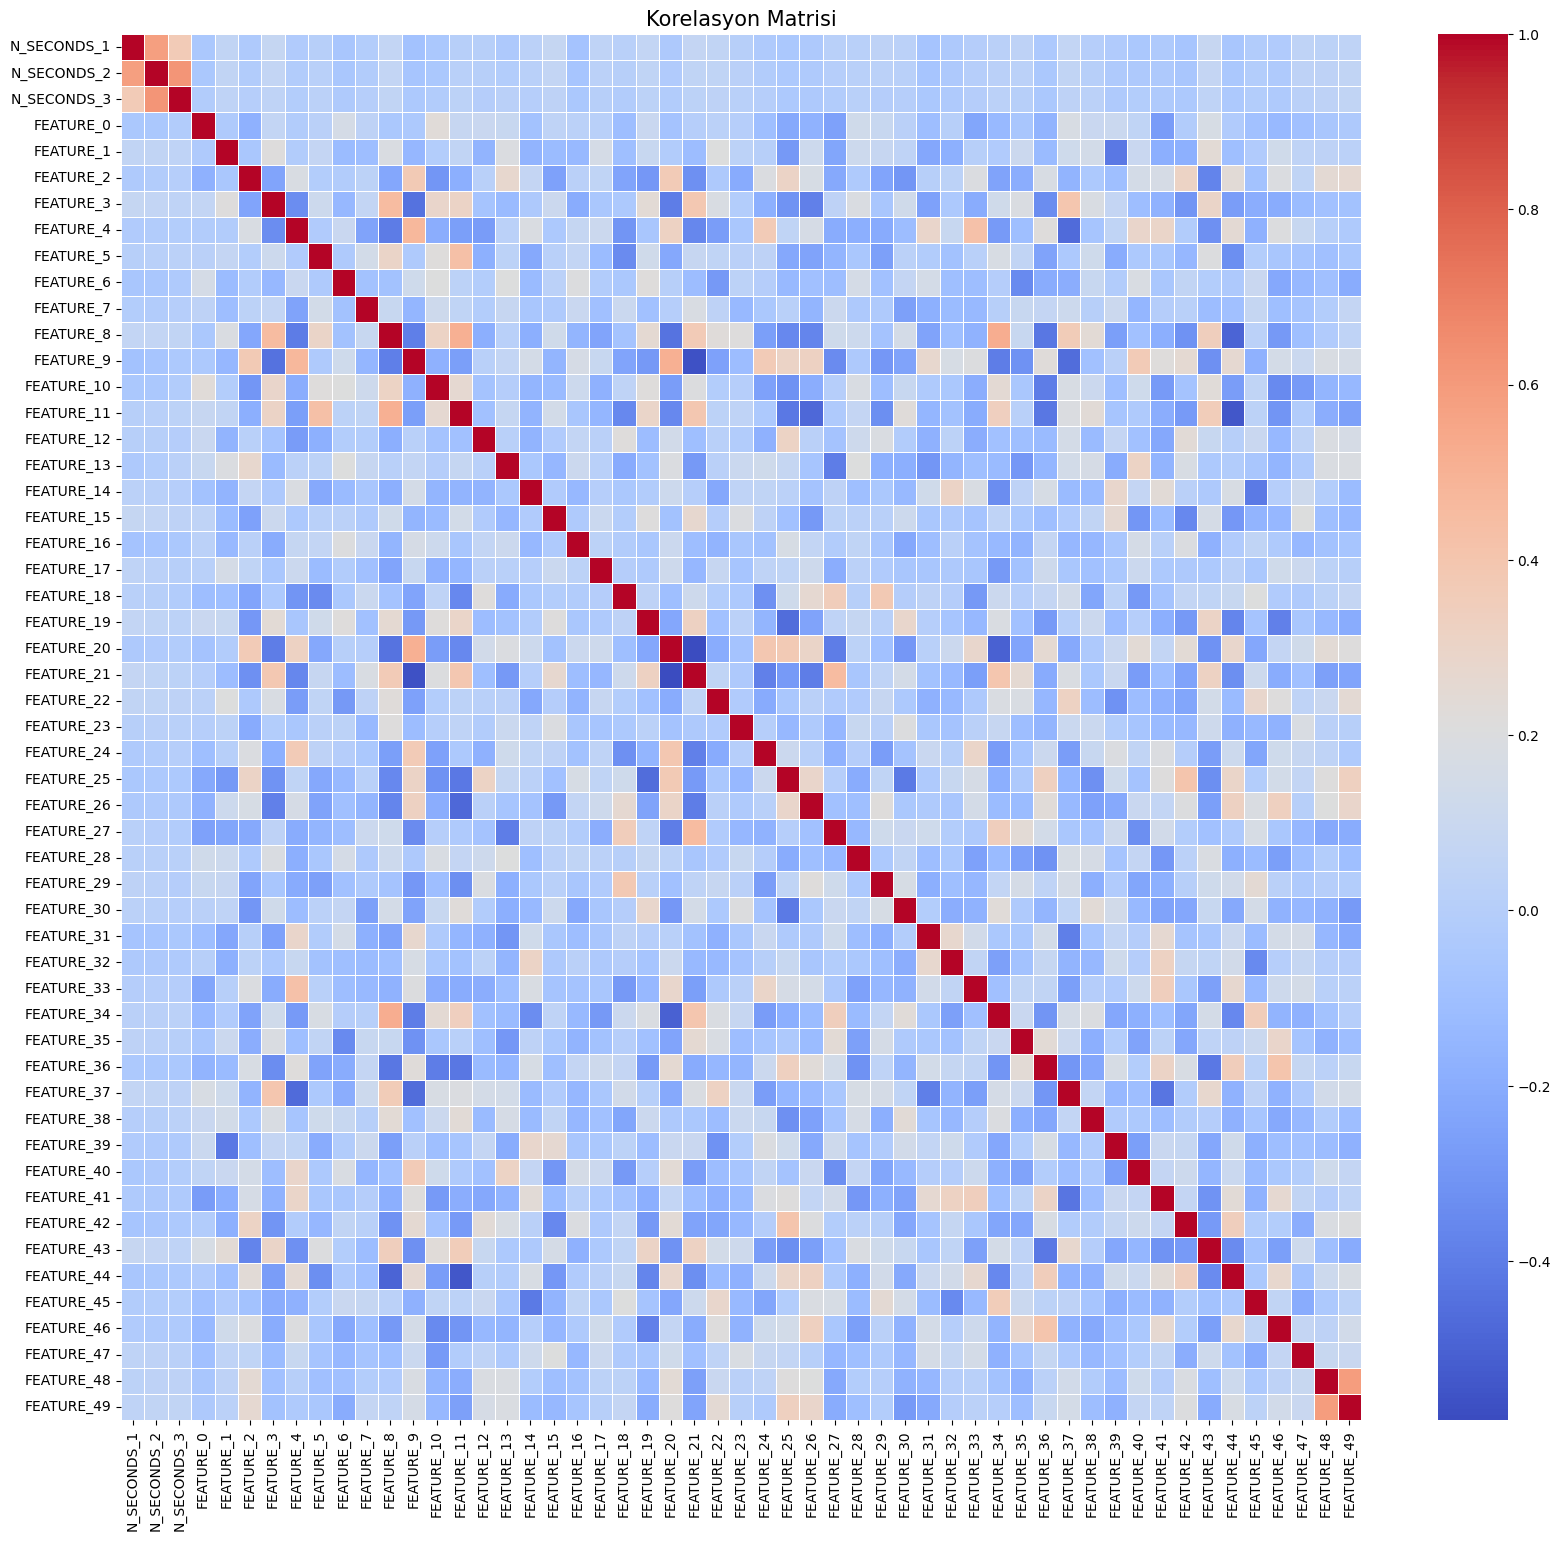

In [285]:
correlation_matrix = df[num_cols].corr()

plt.figure(figsize=(20, 18))

sns.heatmap(correlation_matrix, fmt=".2f", cmap="coolwarm", linewidths=.5)

plt.title("Korelasyon Matrisi", fontsize=15)

plt.show()

# Examining Categorical Variables with Each Other

In [50]:
from scipy.stats import chi2_contingency

In [51]:
def chi2_squ(dataframe, cate_1, cate_2):
    contingency_table = pd.crosstab(dataframe[cate_1], dataframe[cate_2])
    row_totals = contingency_table.sum(axis=1)
    contingency_table['RowTotals'] = row_totals
    contingency_table = contingency_table.sort_values(by='RowTotals', ascending=False)
    
    print(f"### {cate_1} - {cate_2} ###")
    chi2, p, dof, expected = chi2_contingency(contingency_table.drop(columns='RowTotals'))
    alpha = 0.05
    print('Chi Square statistic = %.4f, p-value = %.4f' % (chi2, p))
    
    if p > alpha:
        print("H0: The assumption of independence is not rejected; there is no significant relationship between variables.")
    else:
        print("H0: The assumption of independence is rejected; there is a relationship between variables.")
    print('----------------------------------------------------------------------------------')
    
    plt.figure(figsize=(20, 20))
    sns.heatmap(contingency_table.drop(columns='RowTotals').head(10), annot=False, fmt="d", cmap="YlGnBu", linewidths=.5)
    plt.yticks(rotation=0)
    plt.show()

### CARRIER

In [52]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_encoded)

Observations: 94049
Variables: 67
cat_cols: 11
num_cols: 53
cat_but_car: 3
num_but_cat: 11


In [53]:
cat_cols += cat_cat

In [54]:
cat_cols

['MONTH',
 'ID_FREQ',
 'menu1',
 'menu2',
 'menu3',
 'menu4',
 'menu5',
 'menu6',
 'menu7',
 'menu8',
 'menu9',
 'CARRIER',
 'DEVICEBRAND',
 'TARGET']

In [ ]:
for col in cat_cols:
    if col not in  ['CARRIER', 'TARGET']:
        chi2_squ(df_encoded, 'CARRIER', col)

### DEVICEBRAND

In [ ]:
for col in cat_cols:
    if col not in  ['CARRIER', 'TARGET', 'DEVICEBRAND']:
        chi2_squ(df_encoded, 'DEVICEBRAND', col)

### MONTH

In [ ]:
for col in cat_cols:
    if col not in  ['CARRIER', 'TARGET', 'DEVICEBRAND', 'MONTH']:
        chi2_squ(df_encoded, 'MONTH', col)

### ID_FREQ

In [ ]:
for col in cat_cols:
    if col not in  ['CARRIER', 'TARGET', 'DEVICEBRAND', 'MONTH', 'ID_FREQ']:
        chi2_squ(df_encoded, 'ID_FREQ', col)

### menu1

In [ ]:
for col in cat_cols:
    if col not in  ['CARRIER', 'TARGET', 'DEVICEBRAND', 'MONTH', 'ID_FREQ', 'menu1']:
        chi2_squ(df_encoded, 'menu1', col)

### menu2

In [ ]:
for col in cat_cols:
    if col not in  ['CARRIER', 'TARGET', 'DEVICEBRAND', 'MONTH', 'ID_FREQ', 'menu1', 'menu2']:
        chi2_squ(df_encoded, 'menu2', col)

### menu3

In [ ]:
for col in cat_cols:
    if col not in  ['CARRIER', 'TARGET', 'DEVICEBRAND', 'MONTH', 'ID_FREQ', 'menu1', 'menu2', 'menu3']:
        chi2_squ(df_encoded, 'menu3', col)

### menu4

In [ ]:
for col in cat_cols:
    if col not in  ['CARRIER', 'TARGET', 'DEVICEBRAND', 'MONTH', 'ID_FREQ', 'menu1', 'menu2', 'menu3', 'menu4']:
        chi2_squ(df_encoded, 'menu4', col)

### menu5

In [ ]:
for col in cat_cols:
    if col not in  ['CARRIER', 'TARGET', 'DEVICEBRAND', 'MONTH', 'ID_FREQ', 'menu1', 'menu2', 'menu3', 'menu4', 'menu5']:
        chi2_squ(df_encoded, 'menu5', col)

### menu6

In [ ]:
for col in cat_cols:
    if col not in  ['CARRIER', 'TARGET', 'DEVICEBRAND', 'MONTH', 'ID_FREQ', 'menu1', 'menu2', 'menu3', 'menu4', 'menu5', 'menu6']:
        chi2_squ(df_encoded, 'menu6', col)

### menu7

In [ ]:
for col in cat_cols:
    if col not in  ['CARRIER', 'TARGET', 'DEVICEBRAND', 'MONTH', 'ID_FREQ', 'menu1', 'menu2', 'menu3', 'menu4', 'menu5', 'menu6', 'menu7']:
        chi2_squ(df_encoded, 'menu7', col)

### menu9

In [ ]:
chi2_squ(df_encoded, 'menu8', 'menu9')

# OUTLIER VALUES

In [55]:
# Calculating Lower and Upper Values for Outliers
def outlier_thresholds(dataframe, col_name, q1=0.10, q3=0.90):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit 

In [56]:
# To ask if the outlier is a boolean
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    
    if dataframe[(dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit)].any(axis=None):
        return True
    else:
        return False

In [57]:
# To Access Outliers themselves or their indexes
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)
    
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])
        
    if index:
        outliers_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outliers_index

In [58]:
# To Suppress Outliers
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [59]:
# To check how many outliers there are in each column
def count_outliers(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    
    outliers = dataframe[(dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit)]
    
    return outliers.shape[0]


In [60]:
for col in num_cols:
    outlier_count = count_outliers(df_encoded, col)
    print(col, ':', outlier_count)

N_SECONDS_1 : 0
N_SECONDS_2 : 0
N_SECONDS_3 : 0
FEATURE_0 : 3
FEATURE_1 : 4
FEATURE_2 : 2
FEATURE_3 : 1
FEATURE_4 : 14
FEATURE_5 : 0
FEATURE_6 : 6
FEATURE_7 : 7
FEATURE_8 : 20
FEATURE_9 : 1
FEATURE_10 : 0
FEATURE_11 : 0
FEATURE_12 : 1
FEATURE_13 : 1
FEATURE_14 : 4
FEATURE_15 : 3
FEATURE_16 : 8
FEATURE_17 : 4
FEATURE_18 : 0
FEATURE_19 : 0
FEATURE_20 : 0
FEATURE_21 : 0
FEATURE_22 : 0
FEATURE_23 : 1
FEATURE_24 : 1
FEATURE_25 : 12
FEATURE_26 : 2
FEATURE_27 : 22
FEATURE_28 : 2
FEATURE_29 : 0
FEATURE_30 : 8
FEATURE_31 : 26
FEATURE_32 : 3
FEATURE_33 : 8
FEATURE_34 : 1
FEATURE_35 : 36
FEATURE_36 : 2
FEATURE_37 : 6
FEATURE_38 : 13
FEATURE_39 : 2
FEATURE_40 : 5
FEATURE_41 : 2
FEATURE_42 : 3
FEATURE_43 : 0
FEATURE_44 : 0
FEATURE_45 : 2
FEATURE_46 : 0
FEATURE_47 : 3
FEATURE_48 : 3
FEATURE_49 : 0


In [61]:
for col in num_cols:
    replace_with_thresholds(df_encoded, col)

In [62]:
df_encoded.isnull().sum().any()

False

# PREPROCESSING

### FEATURE_48 - FEATURE_49 

<Axes: >

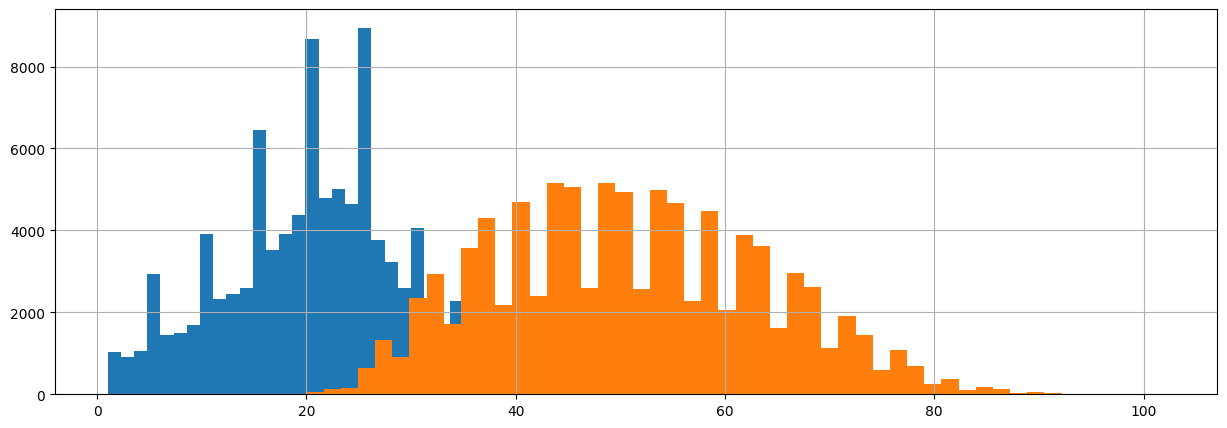

In [63]:
df_encoded['FEATURE_48'].hist(bins=50, figsize=(15, 5))
df_encoded['FEATURE_49'].hist(bins=50, figsize=(15, 5))

<Axes: title={'center': 'FEATURE - 48 + 49'}>

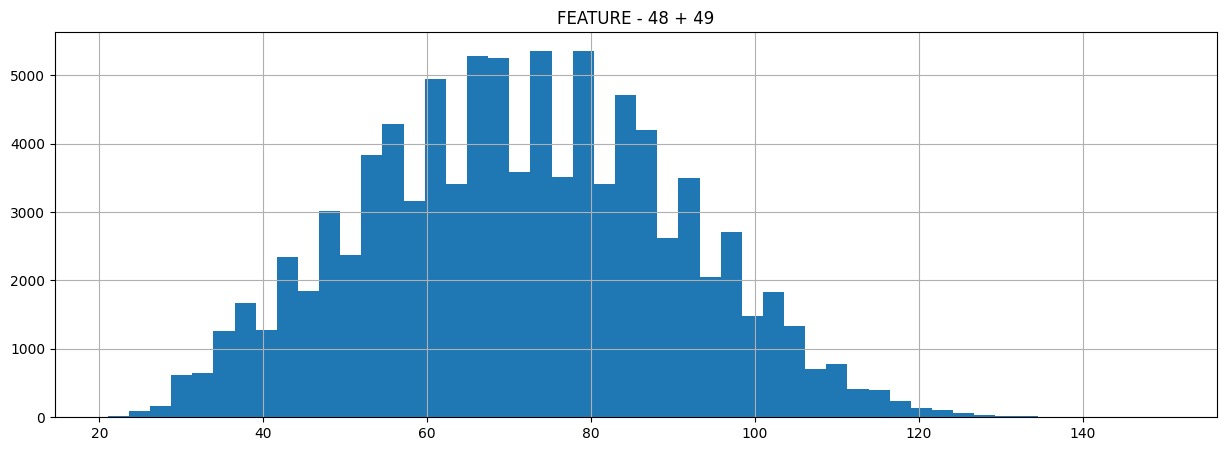

In [64]:
plt.title('FEATURE - 48 + 49')
((df_encoded['FEATURE_48'] + df_encoded['FEATURE_49'])).hist(bins=50, figsize=(15, 5))

In [65]:
df_base = df_encoded.copy()

In [66]:
df_base['FEATURE-48+49'] = df_base['FEATURE_48'] + df_base['FEATURE_49']

In [67]:
df_base.head()

,ID,MONTH,N_SECONDS_1,N_SECONDS_2,N_SECONDS_3,CARRIER,DEVICEBRAND,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,FEATURE_12,FEATURE_13,FEATURE_14,FEATURE_15,FEATURE_16,FEATURE_17,FEATURE_18,FEATURE_19,FEATURE_20,FEATURE_21,FEATURE_22,FEATURE_23,FEATURE_24,FEATURE_25,FEATURE_26,FEATURE_27,FEATURE_28,FEATURE_29,FEATURE_30,FEATURE_31,FEATURE_32,FEATURE_33,FEATURE_34,FEATURE_35,FEATURE_36,FEATURE_37,FEATURE_38,FEATURE_39,FEATURE_40,FEATURE_41,FEATURE_42,FEATURE_43,FEATURE_44,FEATURE_45,FEATURE_46,FEATURE_47,FEATURE_48,FEATURE_49,ID_FREQ,menu1,menu2,menu3,menu4,menu5,menu6,menu7,menu8,menu9,FEATURE-48+49
0,5beefd4d2bf4a4767e0df8108,10,8.565,6.889,5.328,VODAFONE,Apple,-1.198,1.113,-1.123,-0.264,2.161,2.651,0.810,1.516,2.351,-4.608,0.678,-0.555,3.502,-0.765,1.543,-1.458,-1.017,-1.820,0.726,-1.444,1.087,2.102,-0.249,-0.583,-1.330,1.407,1.054,-1.532,1.667,0.251,-0.091,2.676,-0.621,0.163,1.720,-6.139,-0.303,2.784,-3.135,-3.794,0.930,-2.613,-2.033,2.646,-1.023,1.659,-1.559,-2.161,30,58,1,0,1,0,1,1,0,0,0,0,88
1,867285b116c063d5a8482f5be,10,8.554,6.324,6.189,TURKCELL,Samsung,-2.336,2.568,-0.495,0.949,3.568,3.358,0.434,0.886,1.452,-3.184,1.024,1.166,2.916,-1.281,3.019,-3.163,-1.120,-2.798,0.287,-2.029,0.260,0.962,-0.534,-1.311,-0.144,-1.562,1.931,-0.942,-0.000,-1.372,1.225,2.795,-0.961,0.114,1.048,-5.697,0.902,-0.073,-2.366,-0.600,0.815,-0.984,-1.454,-0.022,-0.196,2.776,-0.319,-4.291,21,45,1,0,0,0,1,0,0,1,1,0,66
2,c82a7cbd2e00d9b66c06bcadc,10,8.252,8.094,3.780,TURK TELEKOM,Redmi,-2.561,2.062,-0.185,1.062,4.198,1.551,-0.596,-0.619,2.017,-4.631,-0.663,-0.838,1.821,-2.171,3.695,-0.922,-2.873,-2.042,0.533,-0.128,0.450,2.716,-0.178,0.052,-0.518,-0.043,1.157,-0.527,-0.088,-0.497,1.203,2.742,-0.623,1.757,2.059,-5.359,0.929,1.133,-3.100,-1.253,1.057,-1.669,-3.599,1.674,0.632,1.293,-2.231,-2.384,19,61,2,0,1,0,1,0,0,0,1,0,80
3,f2d2b25073ccc298eced86897,10,8.170,5.040,4.170,TURKCELL,Samsung,-2.530,3.358,-0.851,1.644,2.849,3.887,1.855,0.988,2.066,-5.804,1.931,0.151,3.145,-2.673,0.378,-2.657,-0.378,-3.276,0.003,-0.674,-0.227,1.817,0.068,-0.787,-1.708,-2.000,1.770,0.049,0.230,-0.304,1.659,1.692,-1.105,1.242,2.043,-3.854,0.649,0.944,-3.027,-1.824,0.204,-1.861,-1.220,1.863,0.213,1.030,-1.142,-4.466,2,41,1,1,1,0,0,0,1,0,0,0,43
4,7818c92a58af0f2cb7c361738,10,8.115,6.669,6.572,VODAFONE,Samsung,-2.922,2.096,0.061,-1.488,3.225,2.092,-0.993,0.686,2.090,-2.974,-0.797,-1.459,2.398,-1.308,3.381,-2.664,-2.219,-1.714,1.288,-2.250,2.345,0.403,-0.077,0.289,1.847,1.424,1.888,-1.022,1.021,-0.843,-0.859,2.565,0.412,0.068,0.391,-5.996,2.675,0.203,-3.272,-1.418,2.188,-0.143,-1.876,1.024,-0.186,-0.062,-1.462,-2.371,23,85,2,0,1,0,0,0,1,0,1,0,108


# RARE

In [68]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_base)

Observations: 94049
Variables: 68
cat_cols: 11
num_cols: 54
cat_but_car: 3
num_but_cat: 11


In [69]:
cat_cols

['MONTH',
 'ID_FREQ',
 'menu1',
 'menu2',
 'menu3',
 'menu4',
 'menu5',
 'menu6',
 'menu7',
 'menu8',
 'menu9']

In [70]:
cat_cat = ['CARRIER', 'DEVICEBRAND']

In [71]:
cat_cols = [col for col in cat_cols if 'menu' not in col]

In [72]:
cat_cols += cat_cat

In [73]:
cat_cols

['MONTH', 'ID_FREQ', 'CARRIER', 'DEVICEBRAND']

In [74]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ':', len(dataframe[col].value_counts()), '=>', target)
        result_df = pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                                  "RATIO": 100 * dataframe[col].value_counts() / len(dataframe),
                                  "TARGET_MEAN": dataframe.groupby(col)[target].mean()})
        
        result_df = result_df.sort_values(by="RATIO", ascending=False)
        
        print(result_df, end="\n\n\n")

In [75]:
ohe_target

Index(['menu1', 'menu2', 'menu3', 'menu4', 'menu5', 'menu6', 'menu7', 'menu8', 'menu9'], dtype='object')

In [ ]:
for col in ohe_target:
    rare_analyser(df_base, col, cat_cols)

In [76]:
rare_df = df_base.drop(ohe_target, axis=1)

In [77]:
rare_df = rare_df.drop('ID', axis=1)

In [78]:
def rare_encoder(dataframe, rare_perc, rare_cols):
    temp_df = dataframe.copy()

    rare_columns = [col for col in rare_cols if (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        
        if len(rare_labels) > 1:
            temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

In [79]:
rare_df = rare_encoder(rare_df, 0.005, cat_cols)

In [80]:
ohe_df = df_base.iloc[:, -10:-1]

In [81]:
ohe_df.head()

,menu1,menu2,menu3,menu4,menu5,menu6,menu7,menu8,menu9
0,0,1,0,1,1,0,0,0,0
1,0,0,0,1,0,0,1,1,0
2,0,1,0,1,0,0,0,1,0
3,1,1,0,0,0,1,0,0,0
4,0,1,0,0,0,1,0,1,0


In [82]:
rare_df = pd.concat([rare_df, ohe_df], axis=1)

In [ ]:
for col in ohe_target:
    rare_analyser(rare_df, col, cat_cols)

# DEVICEBRAND PRICE

In [83]:
df_new = rare_df.copy()

### PRICE

In [84]:
df_new['DEVICEBRAND'].value_counts()

DEVICEBRAND
Apple      33238
Samsung    31971
Redmi      13009
Huawei      6600
Rare        3458
Oppo        3247
Poco         989
Gm           959
Realme       578
Name: count, dtype: int64

In [85]:
df_new['MONTH'].value_counts()

MONTH
12    44433
11    34485
10    15131
Name: count, dtype: int64

- **We took the average of the cheapest and most expensive 5 phone prices from 5 different sellers for each phone model, on a monthly basis, via Cimri.com.**

In [86]:
df_new.loc[(df_new['DEVICEBRAND'] == 'Apple') & (df_new['MONTH'] == 10), 'NEW_DVCE_PRICE'] = 28897.8
df_new.loc[(df_new['DEVICEBRAND'] == 'Apple') & (df_new['MONTH'] == 11), 'NEW_DVCE_PRICE'] = 30568.7
df_new.loc[(df_new['DEVICEBRAND'] == 'Apple') & (df_new['MONTH'] == 12), 'NEW_DVCE_PRICE'] = 32750.5

df_new.loc[(df_new['DEVICEBRAND'] == 'Samsung') & (df_new['MONTH'] == 10), 'NEW_DVCE_PRICE'] = 14924.2
df_new.loc[(df_new['DEVICEBRAND'] == 'Samsung') & (df_new['MONTH'] == 11), 'NEW_DVCE_PRICE'] = 15138.7
df_new.loc[(df_new['DEVICEBRAND'] == 'Samsung') & (df_new['MONTH'] == 12), 'NEW_DVCE_PRICE'] = 16167.2

df_new.loc[(df_new['DEVICEBRAND'] == 'Redmi') & (df_new['MONTH'] == 10), 'NEW_DVCE_PRICE'] = 5726.6
df_new.loc[(df_new['DEVICEBRAND'] == 'Redmi') & (df_new['MONTH'] == 11), 'NEW_DVCE_PRICE'] = 5806.3
df_new.loc[(df_new['DEVICEBRAND'] == 'Redmi') & (df_new['MONTH'] == 12), 'NEW_DVCE_PRICE'] = 6157.1

df_new.loc[(df_new['DEVICEBRAND'] == 'Huawei') & (df_new['MONTH'] == 10), 'NEW_DVCE_PRICE'] = 14256.3
df_new.loc[(df_new['DEVICEBRAND'] == 'Huawei') & (df_new['MONTH'] == 11), 'NEW_DVCE_PRICE'] = 14549.1
df_new.loc[(df_new['DEVICEBRAND'] == 'Huawei') & (df_new['MONTH'] == 12), 'NEW_DVCE_PRICE'] = 14906.2

df_new.loc[(df_new['DEVICEBRAND'] == 'Oppo') & (df_new['MONTH'] == 10), 'NEW_DVCE_PRICE'] = 5889.1
df_new.loc[(df_new['DEVICEBRAND'] == 'Oppo') & (df_new['MONTH'] == 11), 'NEW_DVCE_PRICE'] = 5963.9
df_new.loc[(df_new['DEVICEBRAND'] == 'Oppo') & (df_new['MONTH'] == 12), 'NEW_DVCE_PRICE'] = 7320.1

df_new.loc[(df_new['DEVICEBRAND'] == 'Poco') & (df_new['MONTH'] == 10), 'NEW_DVCE_PRICE'] = 9687.3
df_new.loc[(df_new['DEVICEBRAND'] == 'Poco') & (df_new['MONTH'] == 11), 'NEW_DVCE_PRICE'] = 9483.4
df_new.loc[(df_new['DEVICEBRAND'] == 'Poco') & (df_new['MONTH'] == 12), 'NEW_DVCE_PRICE'] = 9936.5

df_new.loc[(df_new['DEVICEBRAND'] == 'Gm') & (df_new['MONTH'] == 10), 'NEW_DVCE_PRICE'] = 3921.2
df_new.loc[(df_new['DEVICEBRAND'] == 'Gm') & (df_new['MONTH'] == 11), 'NEW_DVCE_PRICE'] = 3942.5
df_new.loc[(df_new['DEVICEBRAND'] == 'Gm') & (df_new['MONTH'] == 12), 'NEW_DVCE_PRICE'] = 3914.1

df_new.loc[(df_new['DEVICEBRAND'] == 'Realme') & (df_new['MONTH'] == 10), 'NEW_DVCE_PRICE'] = 5971.3
df_new.loc[(df_new['DEVICEBRAND'] == 'Realme') & (df_new['MONTH'] == 11), 'NEW_DVCE_PRICE'] = 6159.5
df_new.loc[(df_new['DEVICEBRAND'] == 'Realme') & (df_new['MONTH'] == 12), 'NEW_DVCE_PRICE'] = 6762.7

df_new.loc[(df_new['DEVICEBRAND'] == 'Rare') & (df_new['MONTH'] == 10), 'NEW_DVCE_PRICE'] = 2800
df_new.loc[(df_new['DEVICEBRAND'] == 'Rare') & (df_new['MONTH'] == 11), 'NEW_DVCE_PRICE'] = 2850
df_new.loc[(df_new['DEVICEBRAND'] == 'Rare') & (df_new['MONTH'] == 12), 'NEW_DVCE_PRICE'] = 2900


In [87]:
print(pd.DataFrame({'NEW_DVCE_PRICE': df_new['NEW_DVCE_PRICE'].value_counts(),
              'RATIO': 100 * df_new['NEW_DVCE_PRICE'].value_counts() / len(df_new)}))

                NEW_DVCE_PRICE  RATIO
NEW_DVCE_PRICE                       
32750.500                16681 17.736
16167.200                14480 15.396
15138.700                12335 13.116
30568.700                11333 12.050
6157.100                  6074  6.458
28897.800                 5224  5.555
14924.200                 5156  5.482
5806.300                  4886  5.195
14906.200                 3027  3.219
14549.100                 2482  2.639
5726.600                  2049  2.179
2900.000                  1563  1.662
7320.100                  1481  1.575
2850.000                  1269  1.349
5963.900                  1216  1.293
14256.300                 1091  1.160
2800.000                   626  0.666
5889.100                   550  0.585
9936.500                   440  0.468
3914.100                   424  0.451
9483.400                   376  0.400
3942.500                   364  0.387
6762.700                   263  0.280
6159.500                   224  0.238
9687.300    

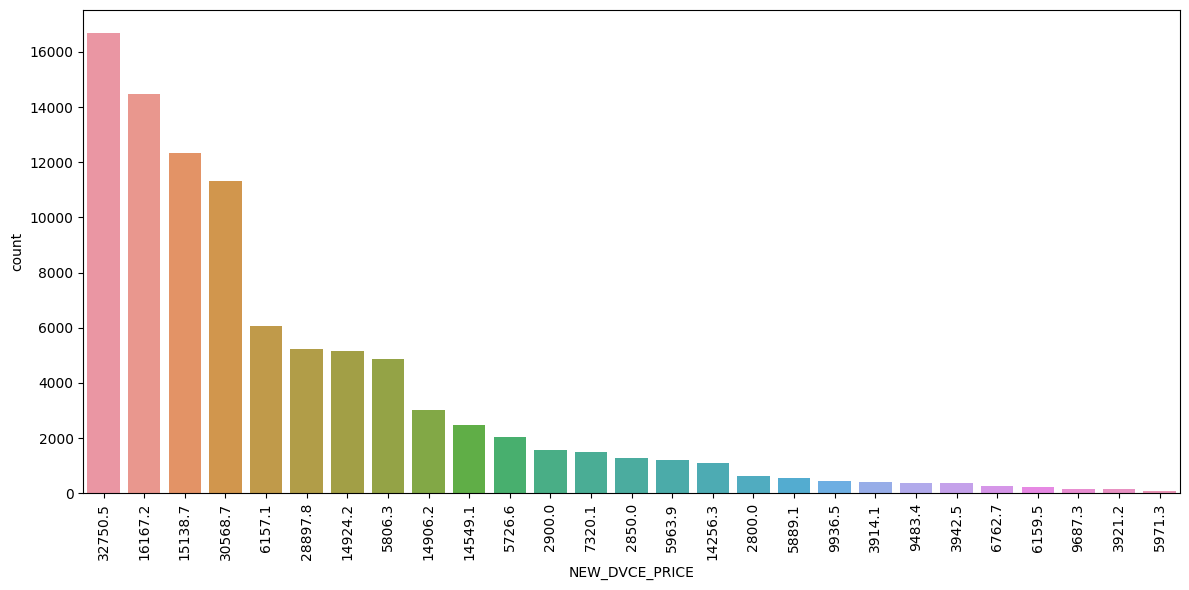

In [88]:
oct_dvc_price = df_new['NEW_DVCE_PRICE'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.countplot(x=df_new['NEW_DVCE_PRICE'], data=df_new, order=oct_dvc_price.index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
plt.tight_layout()
plt.show()

### TUFE

In [89]:
df_new.loc[(df_new['MONTH'] == 10), 'NEW_TUFE'] = 3.54
df_new.loc[(df_new['MONTH'] == 11), 'NEW_TUFE'] = 2.88
df_new.loc[(df_new['MONTH'] == 12), 'NEW_TUFE'] = 1.88

In [90]:
print(pd.DataFrame({'NEW_TUFE': df_new['NEW_TUFE'].value_counts(),
              'RATIO': 100 * df_new['NEW_TUFE'].value_counts() / len(df_new)}))

          NEW_TUFE  RATIO
NEW_TUFE                 
1.880        44433 47.245
2.880        34485 36.667
3.540        15131 16.088


### UFE

In [91]:
df_new.loc[(df_new['MONTH'] == 10), 'NEW_UFE'] = 7.83
df_new.loc[(df_new['MONTH'] == 11), 'NEW_UFE'] = 0.74
df_new.loc[(df_new['MONTH'] == 12), 'NEW_UFE'] = 0.24

### DOLAR

In [92]:
df_new.loc[(df_new['MONTH'] == 10), 'NEW_DOLAR'] = 18.5786
df_new.loc[(df_new['MONTH'] == 11), 'NEW_DOLAR'] = 18.5859
df_new.loc[(df_new['MONTH'] == 12), 'NEW_DOLAR'] = 18.6493

### NEW_DVCE_PRICE

<Axes: >

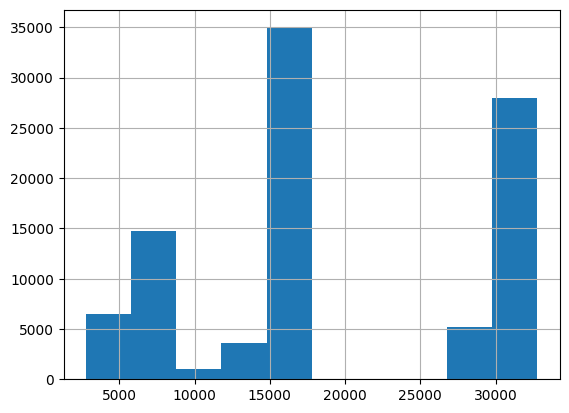

In [93]:
df_new['NEW_DVCE_PRICE'].hist()

In [94]:
df_new['NEW_DVCE_PRICE'].describe(([0, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99, 1]))

count   94049.000
mean    18757.206
std     10155.236
min      2800.000
0%       2800.000
5%       5726.600
10%      5806.300
25%     14549.100
50%     16167.200
75%     30568.700
90%     32750.500
95%     32750.500
99%     32750.500
100%    32750.500
max     32750.500
Name: NEW_DVCE_PRICE, dtype: float64

In [95]:
df_new.loc[(df_new['NEW_DVCE_PRICE'] < 5000), 'NEW_DVCE_PRICE_CAT'] = 'dusuk'
df_new.loc[(df_new['NEW_DVCE_PRICE'] >= 5000) & (df_new['NEW_DVCE_PRICE'] < 10000), 'NEW_DVCE_PRICE_CAT'] = 'orta'
df_new.loc[(df_new['NEW_DVCE_PRICE'] >= 10000) & (df_new['NEW_DVCE_PRICE'] < 20000), 'NEW_DVCE_PRICE_CAT'] = 'iyi'
df_new.loc[(df_new['NEW_DVCE_PRICE'] >= 20000), 'NEW_DVCE_PRICE_CAT'] = 'cok_iyi'

In [96]:
print(pd.DataFrame({'NEW_DVCE_PRICE_CAT': df_new['NEW_DVCE_PRICE_CAT'].value_counts(),
              'RATIO': 100 * df_new['NEW_DVCE_PRICE_CAT'].value_counts() / len(df_new)}))

                    NEW_DVCE_PRICE_CAT  RATIO
NEW_DVCE_PRICE_CAT                           
iyi                              38571 41.012
cok_iyi                          33238 35.341
orta                             17823 18.951
dusuk                             4417  4.696


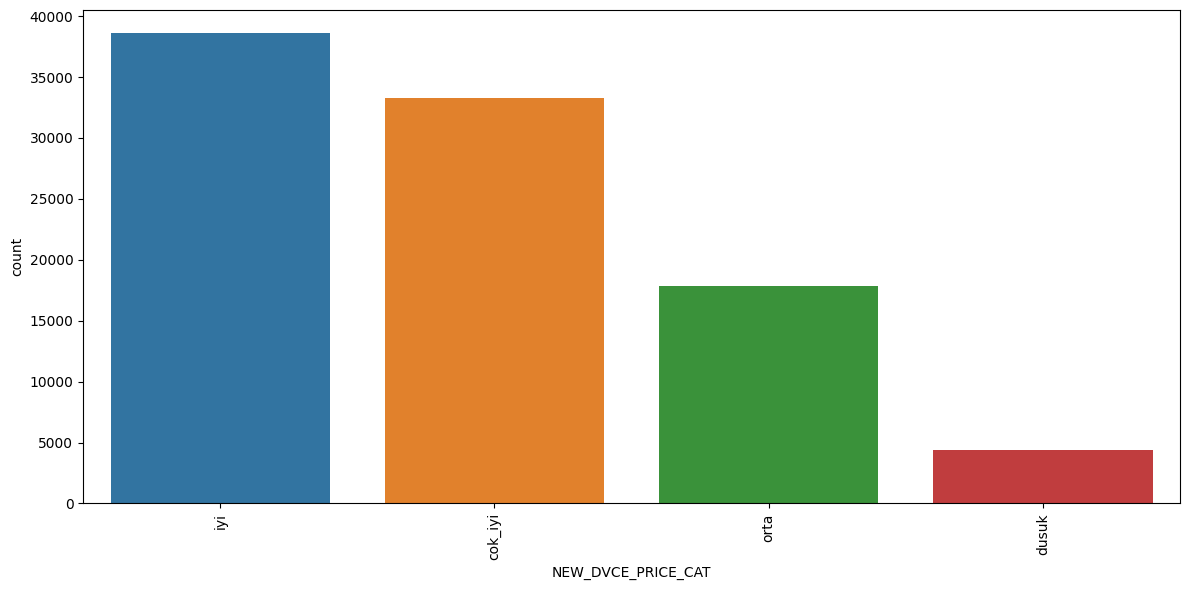

In [97]:
dvc_price_cat = df_new['NEW_DVCE_PRICE_CAT'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.countplot(x=df_new['NEW_DVCE_PRICE_CAT'], data=df_new, order=dvc_price_cat.index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
plt.tight_layout()
plt.show()

### FEATURE_48

In [98]:
feature_48_max = df_new['FEATURE_48'].max()

In [99]:
bins_feature_48 = [0, 10, 20, 30, 40, feature_48_max]

In [100]:
bins_feature_48

[0, 10, 20, 30, 40, 64]

In [101]:
labels_feature_48 = ['feature_48-1_10', 'feature_48-11_20', 'feature_48-21_30', 'feature_48-31_40', 'feature_48-41_' + str(feature_48_max)]

In [102]:
labels_feature_48

['feature_48-1_10',
 'feature_48-11_20',
 'feature_48-21_30',
 'feature_48-31_40',
 'feature_48-41_64']

In [103]:
df_new['FEATURE_48_CUT'] = pd.cut(x=df_new['FEATURE_48'], bins=bins_feature_48 , labels=labels_feature_48)

In [104]:
print(pd.DataFrame({'FEATURE_48_CUT': df_new['FEATURE_48_CUT'].value_counts(),
              'RATIO': 100 * df_new['FEATURE_48_CUT'].value_counts() / len(df_new)}))

                  FEATURE_48_CUT  RATIO
FEATURE_48_CUT                         
feature_48-21_30           39597 42.103
feature_48-11_20           31917 33.937
feature_48-1_10            12442 13.229
feature_48-31_40            9471 10.070
feature_48-41_64             622  0.661


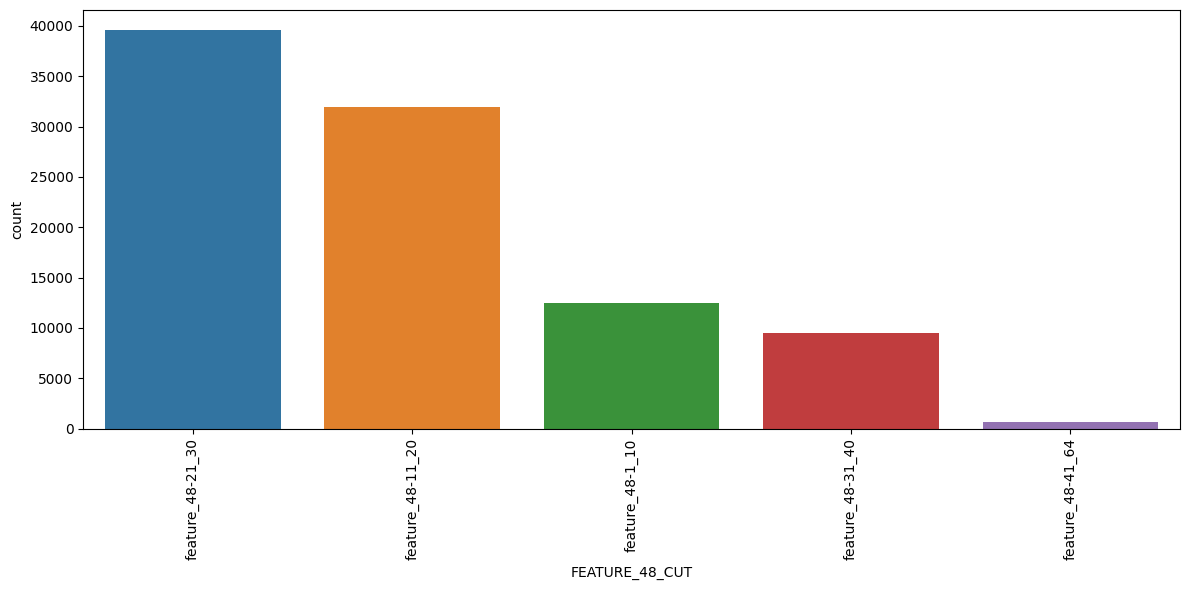

In [105]:
fea_48 = df_new['FEATURE_48_CUT'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.countplot(x=df_new['FEATURE_48_CUT'], data=df_new, order=fea_48.index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
plt.tight_layout()
plt.show()

### FEATURE_49

In [106]:
feature_49_min = df_new['FEATURE_49'].min()
feature_49_max = df_new['FEATURE_49'].max()

In [107]:
bins_feature_49 = [(feature_49_min - 1), 30, 40, 50, 60, 70, feature_49_max]

In [108]:
bins_feature_49

[19, 30, 40, 50, 60, 70, 102]

In [109]:
labels_feature_49 = ['feature_49-' + str(feature_49_min) +  '_30', 'feature_49-31_40', 'feature_49-41_50', 'feature_49-51_60',  'feature_49-61_70', 'feature_49-71_' + str(feature_49_max)]

In [110]:
labels_feature_49

['feature_49-20_30',
 'feature_49-31_40',
 'feature_49-41_50',
 'feature_49-51_60',
 'feature_49-61_70',
 'feature_49-71_102']

In [111]:
df_new['FEATURE_49_CUT'] = pd.cut(x=df_new['FEATURE_49'], bins=bins_feature_49 , labels=labels_feature_49)

In [112]:
print(pd.DataFrame({'FEATURE_49_CUT': df_new['FEATURE_49_CUT'].value_counts(),
              'RATIO': 100 * df_new['FEATURE_49_CUT'].value_counts() / len(df_new)}))

                   FEATURE_49_CUT  RATIO
FEATURE_49_CUT                          
feature_49-41_50            25217 26.813
feature_49-51_60            23456 24.940
feature_49-31_40            18279 19.436
feature_49-61_70            15859 16.862
feature_49-71_102            6945  7.384
feature_49-20_30             4293  4.565


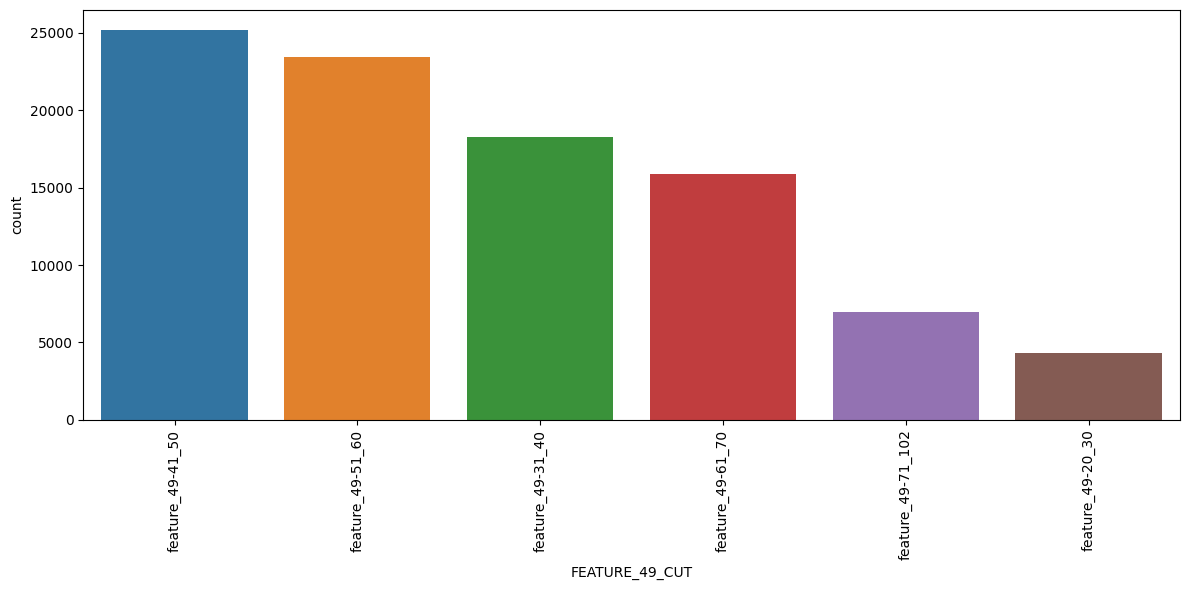

In [113]:
fea_49 = df_new['FEATURE_49_CUT'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.countplot(x=df_new['FEATURE_49_CUT'], data=df_new, order=fea_49.index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
plt.tight_layout()
plt.show()

In [114]:
df_new.isnull().sum().any()

False

### FEATURE - 48_49 - ORDINAL

In [115]:
feature_48_cut_order = ['feature_48-1_10', 'feature_48-11_20', 'feature_48-21_30', 'feature_48-31_40', 'feature_48-41_' + str(feature_48_max)]
feature_49_cut_order = ['feature_49-' + str(feature_49_min) + '_30', 'feature_49-31_40', 'feature_49-41_50', 'feature_49-51_60', 'feature_49-61_70', 'feature_49-71_' + str(feature_49_max)]
dvce_order = ['cok_dusuk', 'dusuk', 'orta', 'iyi', 'cok_iyi']

In [116]:
ord_encoder = OrdinalEncoder(categories=[feature_48_cut_order, feature_49_cut_order, dvce_order],
                            handle_unknown='use_encoded_value',
                            unknown_value=-1)

In [117]:
cut_cols = ['FEATURE_48_CUT', 'FEATURE_49_CUT', 'NEW_DVCE_PRICE_CAT']

In [118]:
df_new[cut_cols] = ord_encoder.fit_transform(df_new[cut_cols])

In [119]:
df_new.head()

,MONTH,N_SECONDS_1,N_SECONDS_2,N_SECONDS_3,CARRIER,DEVICEBRAND,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,FEATURE_12,FEATURE_13,FEATURE_14,FEATURE_15,FEATURE_16,FEATURE_17,FEATURE_18,FEATURE_19,FEATURE_20,FEATURE_21,FEATURE_22,FEATURE_23,FEATURE_24,FEATURE_25,FEATURE_26,FEATURE_27,FEATURE_28,FEATURE_29,FEATURE_30,FEATURE_31,FEATURE_32,FEATURE_33,FEATURE_34,FEATURE_35,FEATURE_36,FEATURE_37,FEATURE_38,FEATURE_39,FEATURE_40,FEATURE_41,FEATURE_42,FEATURE_43,FEATURE_44,FEATURE_45,FEATURE_46,FEATURE_47,FEATURE_48,FEATURE_49,ID_FREQ,FEATURE-48+49,menu1,menu2,menu3,menu4,menu5,menu6,menu7,menu8,menu9,NEW_DVCE_PRICE,NEW_TUFE,NEW_UFE,NEW_DOLAR,NEW_DVCE_PRICE_CAT,FEATURE_48_CUT,FEATURE_49_CUT
0,10,8.565,6.889,5.328,VODAFONE,Apple,-1.198,1.113,-1.123,-0.264,2.161,2.651,0.810,1.516,2.351,-4.608,0.678,-0.555,3.502,-0.765,1.543,-1.458,-1.017,-1.820,0.726,-1.444,1.087,2.102,-0.249,-0.583,-1.330,1.407,1.054,-1.532,1.667,0.251,-0.091,2.676,-0.621,0.163,1.720,-6.139,-0.303,2.784,-3.135,-3.794,0.930,-2.613,-2.033,2.646,-1.023,1.659,-1.559,-2.161,30,58,1,88,0,1,0,1,1,0,0,0,0,28897.800,3.540,7.830,18.579,4.000,2.000,3.000
1,10,8.554,6.324,6.189,TURKCELL,Samsung,-2.336,2.568,-0.495,0.949,3.568,3.358,0.434,0.886,1.452,-3.184,1.024,1.166,2.916,-1.281,3.019,-3.163,-1.120,-2.798,0.287,-2.029,0.260,0.962,-0.534,-1.311,-0.144,-1.562,1.931,-0.942,-0.000,-1.372,1.225,2.795,-0.961,0.114,1.048,-5.697,0.902,-0.073,-2.366,-0.600,0.815,-0.984,-1.454,-0.022,-0.196,2.776,-0.319,-4.291,21,45,1,66,0,0,0,1,0,0,1,1,0,14924.200,3.540,7.830,18.579,3.000,2.000,2.000
2,10,8.252,8.094,3.780,TURK TELEKOM,Redmi,-2.561,2.062,-0.185,1.062,4.198,1.551,-0.596,-0.619,2.017,-4.631,-0.663,-0.838,1.821,-2.171,3.695,-0.922,-2.873,-2.042,0.533,-0.128,0.450,2.716,-0.178,0.052,-0.518,-0.043,1.157,-0.527,-0.088,-0.497,1.203,2.742,-0.623,1.757,2.059,-5.359,0.929,1.133,-3.100,-1.253,1.057,-1.669,-3.599,1.674,0.632,1.293,-2.231,-2.384,19,61,2,80,0,1,0,1,0,0,0,1,0,5726.600,3.540,7.830,18.579,2.000,1.000,4.000
3,10,8.170,5.040,4.170,TURKCELL,Samsung,-2.530,3.358,-0.851,1.644,2.849,3.887,1.855,0.988,2.066,-5.804,1.931,0.151,3.145,-2.673,0.378,-2.657,-0.378,-3.276,0.003,-0.674,-0.227,1.817,0.068,-0.787,-1.708,-2.000,1.770,0.049,0.230,-0.304,1.659,1.692,-1.105,1.242,2.043,-3.854,0.649,0.944,-3.027,-1.824,0.204,-1.861,-1.220,1.863,0.213,1.030,-1.142,-4.466,2,41,1,43,1,1,0,0,0,1,0,0,0,14924.200,3.540,7.830,18.579,3.000,0.000,2.000
4,10,8.115,6.669,6.572,VODAFONE,Samsung,-2.922,2.096,0.061,-1.488,3.225,2.092,-0.993,0.686,2.090,-2.974,-0.797,-1.459,2.398,-1.308,3.381,-2.664,-2.219,-1.714,1.288,-2.250,2.345,0.403,-0.077,0.289,1.847,1.424,1.888,-1.022,1.021,-0.843,-0.859,2.565,0.412,0.068,0.391,-5.996,2.675,0.203,-3.272,-1.418,2.188,-0.143,-1.876,1.024,-0.186,-0.062,-1.462,-2.371,23,85,2,108,0,1,0,0,0,1,0,1,0,14924.200,3.540,7.830,18.579,3.000,2.000,5.000


In [120]:
df_new['FEATURE_48_CUT'] = df_new['FEATURE_48_CUT'].astype('int64')
df_new['FEATURE_49_CUT'] = df_new['FEATURE_49_CUT'].astype('int64')
df_new['NEW_DVCE_PRICE_CAT'] = df_new['NEW_DVCE_PRICE_CAT'].astype('int64')

In [121]:
df_new.head()

,MONTH,N_SECONDS_1,N_SECONDS_2,N_SECONDS_3,CARRIER,DEVICEBRAND,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,FEATURE_12,FEATURE_13,FEATURE_14,FEATURE_15,FEATURE_16,FEATURE_17,FEATURE_18,FEATURE_19,FEATURE_20,FEATURE_21,FEATURE_22,FEATURE_23,FEATURE_24,FEATURE_25,FEATURE_26,FEATURE_27,FEATURE_28,FEATURE_29,FEATURE_30,FEATURE_31,FEATURE_32,FEATURE_33,FEATURE_34,FEATURE_35,FEATURE_36,FEATURE_37,FEATURE_38,FEATURE_39,FEATURE_40,FEATURE_41,FEATURE_42,FEATURE_43,FEATURE_44,FEATURE_45,FEATURE_46,FEATURE_47,FEATURE_48,FEATURE_49,ID_FREQ,FEATURE-48+49,menu1,menu2,menu3,menu4,menu5,menu6,menu7,menu8,menu9,NEW_DVCE_PRICE,NEW_TUFE,NEW_UFE,NEW_DOLAR,NEW_DVCE_PRICE_CAT,FEATURE_48_CUT,FEATURE_49_CUT
0,10,8.565,6.889,5.328,VODAFONE,Apple,-1.198,1.113,-1.123,-0.264,2.161,2.651,0.810,1.516,2.351,-4.608,0.678,-0.555,3.502,-0.765,1.543,-1.458,-1.017,-1.820,0.726,-1.444,1.087,2.102,-0.249,-0.583,-1.330,1.407,1.054,-1.532,1.667,0.251,-0.091,2.676,-0.621,0.163,1.720,-6.139,-0.303,2.784,-3.135,-3.794,0.930,-2.613,-2.033,2.646,-1.023,1.659,-1.559,-2.161,30,58,1,88,0,1,0,1,1,0,0,0,0,28897.800,3.540,7.830,18.579,4,2,3
1,10,8.554,6.324,6.189,TURKCELL,Samsung,-2.336,2.568,-0.495,0.949,3.568,3.358,0.434,0.886,1.452,-3.184,1.024,1.166,2.916,-1.281,3.019,-3.163,-1.120,-2.798,0.287,-2.029,0.260,0.962,-0.534,-1.311,-0.144,-1.562,1.931,-0.942,-0.000,-1.372,1.225,2.795,-0.961,0.114,1.048,-5.697,0.902,-0.073,-2.366,-0.600,0.815,-0.984,-1.454,-0.022,-0.196,2.776,-0.319,-4.291,21,45,1,66,0,0,0,1,0,0,1,1,0,14924.200,3.540,7.830,18.579,3,2,2
2,10,8.252,8.094,3.780,TURK TELEKOM,Redmi,-2.561,2.062,-0.185,1.062,4.198,1.551,-0.596,-0.619,2.017,-4.631,-0.663,-0.838,1.821,-2.171,3.695,-0.922,-2.873,-2.042,0.533,-0.128,0.450,2.716,-0.178,0.052,-0.518,-0.043,1.157,-0.527,-0.088,-0.497,1.203,2.742,-0.623,1.757,2.059,-5.359,0.929,1.133,-3.100,-1.253,1.057,-1.669,-3.599,1.674,0.632,1.293,-2.231,-2.384,19,61,2,80,0,1,0,1,0,0,0,1,0,5726.600,3.540,7.830,18.579,2,1,4
3,10,8.170,5.040,4.170,TURKCELL,Samsung,-2.530,3.358,-0.851,1.644,2.849,3.887,1.855,0.988,2.066,-5.804,1.931,0.151,3.145,-2.673,0.378,-2.657,-0.378,-3.276,0.003,-0.674,-0.227,1.817,0.068,-0.787,-1.708,-2.000,1.770,0.049,0.230,-0.304,1.659,1.692,-1.105,1.242,2.043,-3.854,0.649,0.944,-3.027,-1.824,0.204,-1.861,-1.220,1.863,0.213,1.030,-1.142,-4.466,2,41,1,43,1,1,0,0,0,1,0,0,0,14924.200,3.540,7.830,18.579,3,0,2
4,10,8.115,6.669,6.572,VODAFONE,Samsung,-2.922,2.096,0.061,-1.488,3.225,2.092,-0.993,0.686,2.090,-2.974,-0.797,-1.459,2.398,-1.308,3.381,-2.664,-2.219,-1.714,1.288,-2.250,2.345,0.403,-0.077,0.289,1.847,1.424,1.888,-1.022,1.021,-0.843,-0.859,2.565,0.412,0.068,0.391,-5.996,2.675,0.203,-3.272,-1.418,2.188,-0.143,-1.876,1.024,-0.186,-0.062,-1.462,-2.371,23,85,2,108,0,1,0,0,0,1,0,1,0,14924.200,3.540,7.830,18.579,3,2,5


### FEATURE_48_CUT - TUFE

In [122]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_new)

Observations: 94049
Variables: 74
cat_cols: 19
num_cols: 55
cat_but_car: 0
num_but_cat: 17


In [123]:
cat_cols

['CARRIER',
 'DEVICEBRAND',
 'MONTH',
 'ID_FREQ',
 'menu1',
 'menu2',
 'menu3',
 'menu4',
 'menu5',
 'menu6',
 'menu7',
 'menu8',
 'menu9',
 'NEW_TUFE',
 'NEW_UFE',
 'NEW_DOLAR',
 'NEW_DVCE_PRICE_CAT',
 'FEATURE_48_CUT',
 'FEATURE_49_CUT']

In [124]:
df_new.loc[((df_new['FEATURE_48_CUT'] == 0) & (df_new['NEW_TUFE'] == 1.880)), 'NEW_FEATURE_48_TUFE'] = '0-1.880'
df_new.loc[((df_new['FEATURE_48_CUT'] == 0) & (df_new['NEW_TUFE'] == 2.880)), 'NEW_FEATURE_48_TUFE'] = '0-2.880'
df_new.loc[((df_new['FEATURE_48_CUT'] == 0) & (df_new['NEW_TUFE'] == 3.540)), 'NEW_FEATURE_48_TUFE'] = '0-3.540'

df_new.loc[((df_new['FEATURE_48_CUT'] == 1) & (df_new['NEW_TUFE'] == 1.880)), 'NEW_FEATURE_48_TUFE'] = '1-1.880'
df_new.loc[((df_new['FEATURE_48_CUT'] == 1) & (df_new['NEW_TUFE'] == 2.880)), 'NEW_FEATURE_48_TUFE'] = '1-2.880'
df_new.loc[((df_new['FEATURE_48_CUT'] == 1) & (df_new['NEW_TUFE'] == 3.540)), 'NEW_FEATURE_48_TUFE'] = '1-3.540'

df_new.loc[((df_new['FEATURE_48_CUT'] == 2) & (df_new['NEW_TUFE'] == 1.880)), 'NEW_FEATURE_48_TUFE'] = '2-1.880'
df_new.loc[((df_new['FEATURE_48_CUT'] == 2) & (df_new['NEW_TUFE'] == 2.880)), 'NEW_FEATURE_48_TUFE'] = '2-2.880'
df_new.loc[((df_new['FEATURE_48_CUT'] == 2) & (df_new['NEW_TUFE'] == 3.540)), 'NEW_FEATURE_48_TUFE'] = '2-3.540'

df_new.loc[((df_new['FEATURE_48_CUT'] == 3) & (df_new['NEW_TUFE'] == 1.880)), 'NEW_FEATURE_48_TUFE'] = '3-1.880'
df_new.loc[((df_new['FEATURE_48_CUT'] == 3) & (df_new['NEW_TUFE'] == 2.880)), 'NEW_FEATURE_48_TUFE'] = '3-2.880'
df_new.loc[((df_new['FEATURE_48_CUT'] == 3) & (df_new['NEW_TUFE'] == 3.540)), 'NEW_FEATURE_48_TUFE'] = '3-3.540'

df_new.loc[((df_new['FEATURE_48_CUT'] == 4) & (df_new['NEW_TUFE'] == 1.880)), 'NEW_FEATURE_48_TUFE'] = '4-1.880'
df_new.loc[((df_new['FEATURE_48_CUT'] == 4) & (df_new['NEW_TUFE'] == 2.880)), 'NEW_FEATURE_48_TUFE'] = '4-2.880'
df_new.loc[((df_new['FEATURE_48_CUT'] == 4) & (df_new['NEW_TUFE'] == 3.540)), 'NEW_FEATURE_48_TUFE'] = '4-3.540'

In [125]:
print(pd.DataFrame({'NEW_FEATURE_48_TUFE': df_new['NEW_FEATURE_48_TUFE'].value_counts(),
              'RATIO': 100 * df_new['NEW_FEATURE_48_TUFE'].value_counts() / len(df_new)}))

                     NEW_FEATURE_48_TUFE  RATIO
NEW_FEATURE_48_TUFE                            
2-1.880                            18734 19.919
1-1.880                            15214 16.177
2-2.880                            14554 15.475
1-2.880                            11718 12.459
2-3.540                             6309  6.708
0-1.880                             5783  6.149
1-3.540                             4985  5.300
0-2.880                             4577  4.867
3-1.880                             4414  4.693
3-2.880                             3419  3.635
0-3.540                             2082  2.214
3-3.540                             1638  1.742
4-1.880                              288  0.306
4-2.880                              217  0.231
4-3.540                              117  0.124


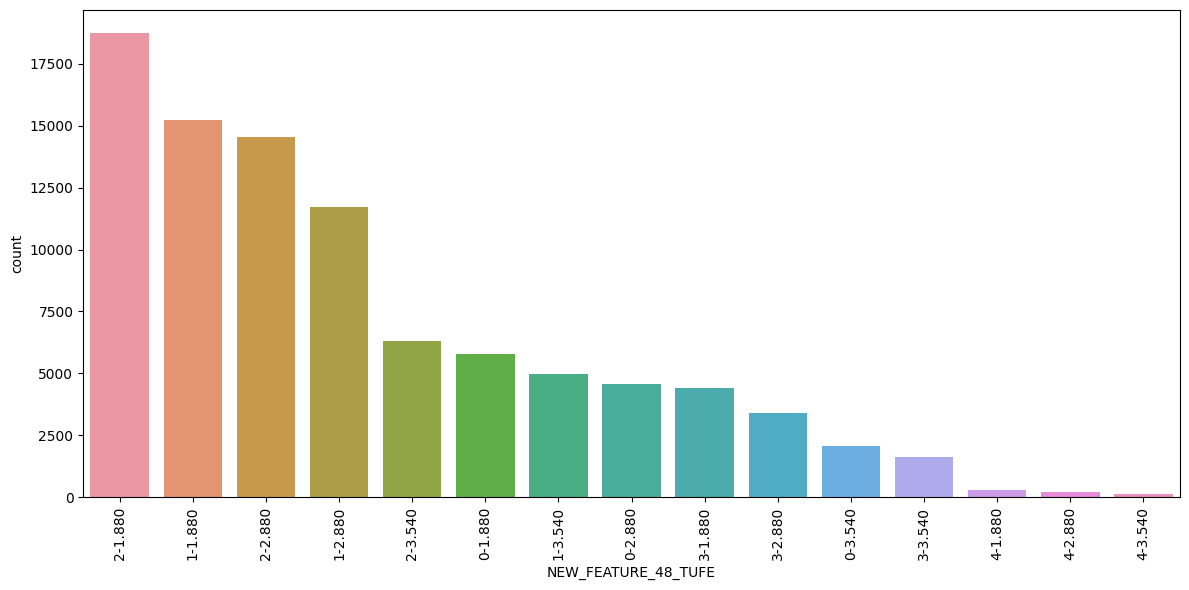

In [126]:
fea_48_tufe = df_new['NEW_FEATURE_48_TUFE'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.countplot(x=df_new['NEW_FEATURE_48_TUFE'], data=df_new, order=fea_48_tufe.index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
plt.tight_layout()
plt.show()

### FEATURE_49_CUT - TUFE

In [127]:
df_new.loc[((df_new['FEATURE_49_CUT'] == 0) & (df_new['NEW_TUFE'] == 1.880)), 'NEW_FEATURE_49_TUFE'] = '0-1.880'
df_new.loc[((df_new['FEATURE_49_CUT'] == 0) & (df_new['NEW_TUFE'] == 2.880)), 'NEW_FEATURE_49_TUFE'] = '0-2.880'
df_new.loc[((df_new['FEATURE_49_CUT'] == 0) & (df_new['NEW_TUFE'] == 3.540)), 'NEW_FEATURE_49_TUFE'] = '0-3.540'

df_new.loc[((df_new['FEATURE_49_CUT'] == 1) & (df_new['NEW_TUFE'] == 1.880)), 'NEW_FEATURE_49_TUFE'] = '1-1.880'
df_new.loc[((df_new['FEATURE_49_CUT'] == 1) & (df_new['NEW_TUFE'] == 2.880)), 'NEW_FEATURE_49_TUFE'] = '1-2.880'
df_new.loc[((df_new['FEATURE_49_CUT'] == 1) & (df_new['NEW_TUFE'] == 3.540)), 'NEW_FEATURE_49_TUFE'] = '1-3.540'

df_new.loc[((df_new['FEATURE_49_CUT'] == 2) & (df_new['NEW_TUFE'] == 1.880)), 'NEW_FEATURE_49_TUFE'] = '2-1.880'
df_new.loc[((df_new['FEATURE_49_CUT'] == 2) & (df_new['NEW_TUFE'] == 2.880)), 'NEW_FEATURE_49_TUFE'] = '2-2.880'
df_new.loc[((df_new['FEATURE_49_CUT'] == 2) & (df_new['NEW_TUFE'] == 3.540)), 'NEW_FEATURE_49_TUFE'] = '2-3.540'

df_new.loc[((df_new['FEATURE_49_CUT'] == 3) & (df_new['NEW_TUFE'] == 1.880)), 'NEW_FEATURE_49_TUFE'] = '3-1.880'
df_new.loc[((df_new['FEATURE_49_CUT'] == 3) & (df_new['NEW_TUFE'] == 2.880)), 'NEW_FEATURE_49_TUFE'] = '3-2.880'
df_new.loc[((df_new['FEATURE_49_CUT'] == 3) & (df_new['NEW_TUFE'] == 3.540)), 'NEW_FEATURE_49_TUFE'] = '3-3.540'

df_new.loc[((df_new['FEATURE_49_CUT'] == 4) & (df_new['NEW_TUFE'] == 1.880)), 'NEW_FEATURE_49_TUFE'] = '4-1.880'
df_new.loc[((df_new['FEATURE_49_CUT'] == 4) & (df_new['NEW_TUFE'] == 2.880)), 'NEW_FEATURE_49_TUFE'] = '4-2.880'
df_new.loc[((df_new['FEATURE_49_CUT'] == 4) & (df_new['NEW_TUFE'] == 3.540)), 'NEW_FEATURE_49_TUFE'] = '4-3.540'

df_new.loc[((df_new['FEATURE_49_CUT'] == 5) & (df_new['NEW_TUFE'] == 1.880)), 'NEW_FEATURE_49_TUFE'] = '5-1.880'
df_new.loc[((df_new['FEATURE_49_CUT'] == 5) & (df_new['NEW_TUFE'] == 2.880)), 'NEW_FEATURE_49_TUFE'] = '5-2.880'
df_new.loc[((df_new['FEATURE_49_CUT'] == 5) & (df_new['NEW_TUFE'] == 3.540)), 'NEW_FEATURE_49_TUFE'] = '5-3.540'


In [128]:
print(pd.DataFrame({'NEW_FEATURE_49_TUFE': df_new['NEW_FEATURE_49_TUFE'].value_counts(),
              'RATIO': 100 * df_new['NEW_FEATURE_49_TUFE'].value_counts() / len(df_new)}))

                     NEW_FEATURE_49_TUFE  RATIO
NEW_FEATURE_49_TUFE                            
2-1.880                            12297 13.075
3-1.880                            11046 11.745
2-2.880                             9363  9.955
1-1.880                             8944  9.510
3-2.880                             8641  9.188
4-1.880                             7126  7.577
1-2.880                             6638  7.058
4-2.880                             5798  6.165
3-3.540                             3769  4.007
2-3.540                             3557  3.782
5-1.880                             3037  3.229
4-3.540                             2935  3.121
1-3.540                             2697  2.868
5-2.880                             2509  2.668
0-1.880                             1983  2.108
0-2.880                             1536  1.633
5-3.540                             1399  1.488
0-3.540                              774  0.823


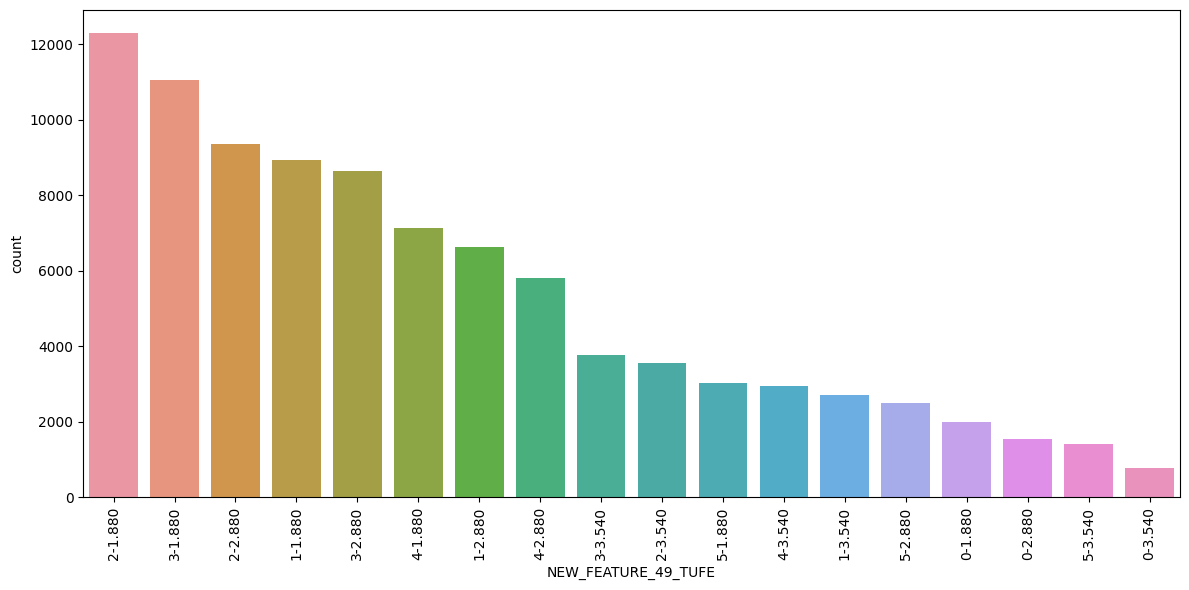

In [129]:
fea_49_tufe = df_new['NEW_FEATURE_49_TUFE'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.countplot(x=df_new['NEW_FEATURE_49_TUFE'], data=df_new, order=fea_49_tufe.index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
plt.tight_layout()
plt.show()

In [130]:
df_new.isnull().sum().any()

False

In [131]:
df_new.head()

,MONTH,N_SECONDS_1,N_SECONDS_2,N_SECONDS_3,CARRIER,DEVICEBRAND,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,FEATURE_12,FEATURE_13,FEATURE_14,FEATURE_15,FEATURE_16,FEATURE_17,FEATURE_18,FEATURE_19,FEATURE_20,FEATURE_21,FEATURE_22,FEATURE_23,FEATURE_24,FEATURE_25,FEATURE_26,FEATURE_27,FEATURE_28,FEATURE_29,FEATURE_30,FEATURE_31,FEATURE_32,FEATURE_33,FEATURE_34,FEATURE_35,FEATURE_36,FEATURE_37,FEATURE_38,FEATURE_39,FEATURE_40,FEATURE_41,FEATURE_42,FEATURE_43,FEATURE_44,FEATURE_45,FEATURE_46,FEATURE_47,FEATURE_48,FEATURE_49,ID_FREQ,FEATURE-48+49,menu1,menu2,menu3,menu4,menu5,menu6,menu7,menu8,menu9,NEW_DVCE_PRICE,NEW_TUFE,NEW_UFE,NEW_DOLAR,NEW_DVCE_PRICE_CAT,FEATURE_48_CUT,FEATURE_49_CUT,NEW_FEATURE_48_TUFE,NEW_FEATURE_49_TUFE
0,10,8.565,6.889,5.328,VODAFONE,Apple,-1.198,1.113,-1.123,-0.264,2.161,2.651,0.810,1.516,2.351,-4.608,0.678,-0.555,3.502,-0.765,1.543,-1.458,-1.017,-1.820,0.726,-1.444,1.087,2.102,-0.249,-0.583,-1.330,1.407,1.054,-1.532,1.667,0.251,-0.091,2.676,-0.621,0.163,1.720,-6.139,-0.303,2.784,-3.135,-3.794,0.930,-2.613,-2.033,2.646,-1.023,1.659,-1.559,-2.161,30,58,1,88,0,1,0,1,1,0,0,0,0,28897.800,3.540,7.830,18.579,4,2,3,2-3.540,3-3.540
1,10,8.554,6.324,6.189,TURKCELL,Samsung,-2.336,2.568,-0.495,0.949,3.568,3.358,0.434,0.886,1.452,-3.184,1.024,1.166,2.916,-1.281,3.019,-3.163,-1.120,-2.798,0.287,-2.029,0.260,0.962,-0.534,-1.311,-0.144,-1.562,1.931,-0.942,-0.000,-1.372,1.225,2.795,-0.961,0.114,1.048,-5.697,0.902,-0.073,-2.366,-0.600,0.815,-0.984,-1.454,-0.022,-0.196,2.776,-0.319,-4.291,21,45,1,66,0,0,0,1,0,0,1,1,0,14924.200,3.540,7.830,18.579,3,2,2,2-3.540,2-3.540
2,10,8.252,8.094,3.780,TURK TELEKOM,Redmi,-2.561,2.062,-0.185,1.062,4.198,1.551,-0.596,-0.619,2.017,-4.631,-0.663,-0.838,1.821,-2.171,3.695,-0.922,-2.873,-2.042,0.533,-0.128,0.450,2.716,-0.178,0.052,-0.518,-0.043,1.157,-0.527,-0.088,-0.497,1.203,2.742,-0.623,1.757,2.059,-5.359,0.929,1.133,-3.100,-1.253,1.057,-1.669,-3.599,1.674,0.632,1.293,-2.231,-2.384,19,61,2,80,0,1,0,1,0,0,0,1,0,5726.600,3.540,7.830,18.579,2,1,4,1-3.540,4-3.540
3,10,8.170,5.040,4.170,TURKCELL,Samsung,-2.530,3.358,-0.851,1.644,2.849,3.887,1.855,0.988,2.066,-5.804,1.931,0.151,3.145,-2.673,0.378,-2.657,-0.378,-3.276,0.003,-0.674,-0.227,1.817,0.068,-0.787,-1.708,-2.000,1.770,0.049,0.230,-0.304,1.659,1.692,-1.105,1.242,2.043,-3.854,0.649,0.944,-3.027,-1.824,0.204,-1.861,-1.220,1.863,0.213,1.030,-1.142,-4.466,2,41,1,43,1,1,0,0,0,1,0,0,0,14924.200,3.540,7.830,18.579,3,0,2,0-3.540,2-3.540
4,10,8.115,6.669,6.572,VODAFONE,Samsung,-2.922,2.096,0.061,-1.488,3.225,2.092,-0.993,0.686,2.090,-2.974,-0.797,-1.459,2.398,-1.308,3.381,-2.664,-2.219,-1.714,1.288,-2.250,2.345,0.403,-0.077,0.289,1.847,1.424,1.888,-1.022,1.021,-0.843,-0.859,2.565,0.412,0.068,0.391,-5.996,2.675,0.203,-3.272,-1.418,2.188,-0.143,-1.876,1.024,-0.186,-0.062,-1.462,-2.371,23,85,2,108,0,1,0,0,0,1,0,1,0,14924.200,3.540,7.830,18.579,3,2,5,2-3.540,5-3.540


# OHE

In [132]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [236]:
df_ohe = df_new.copy()

In [237]:
df_ohe = df_ohe.drop(['NEW_DVCE_PRICE', 'NEW_DOLAR', 'NEW_UFE',],  axis=1)

In [238]:
cat_cols, num_cols, num_but_car = grab_col_names(df_ohe)

Observations: 94049
Variables: 73
cat_cols: 19
num_cols: 54
cat_but_car: 0
num_but_cat: 15


In [239]:
cat_cols

['CARRIER',
 'DEVICEBRAND',
 'NEW_FEATURE_48_TUFE',
 'NEW_FEATURE_49_TUFE',
 'MONTH',
 'ID_FREQ',
 'menu1',
 'menu2',
 'menu3',
 'menu4',
 'menu5',
 'menu6',
 'menu7',
 'menu8',
 'menu9',
 'NEW_TUFE',
 'NEW_DVCE_PRICE_CAT',
 'FEATURE_48_CUT',
 'FEATURE_49_CUT']

In [240]:
ohe_col = [col for col in cat_cols if 'menu' not in col and col not in ['FEATURE_48_CUT', 'FEATURE_49_CUT', 'NEW_DVCE_PRICE_CAT', 'ID_FREQ', 'NEW_TUFE', 'MONTH']]

In [241]:
ohe_col

['CARRIER', 'DEVICEBRAND', 'NEW_FEATURE_48_TUFE', 'NEW_FEATURE_49_TUFE']

In [242]:
one_hot_encoder(df_ohe, ohe_col).shape

(94049, 115)

In [243]:
df_00 = one_hot_encoder(df_ohe, ohe_col)

In [244]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_00)

Observations: 94049
Variables: 115
cat_cols: 61
num_cols: 54
cat_but_car: 0
num_but_cat: 61


In [245]:
def true_false_to_binary(dataframe, binary_val):
    dataframe[binary_val] = dataframe[binary_val].astype(int)
    return dataframe

In [246]:
df_00.head()

,MONTH,N_SECONDS_1,N_SECONDS_2,N_SECONDS_3,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,FEATURE_12,FEATURE_13,FEATURE_14,FEATURE_15,FEATURE_16,FEATURE_17,FEATURE_18,FEATURE_19,FEATURE_20,FEATURE_21,FEATURE_22,FEATURE_23,FEATURE_24,FEATURE_25,FEATURE_26,FEATURE_27,FEATURE_28,FEATURE_29,FEATURE_30,FEATURE_31,FEATURE_32,FEATURE_33,FEATURE_34,FEATURE_35,FEATURE_36,FEATURE_37,FEATURE_38,FEATURE_39,FEATURE_40,FEATURE_41,FEATURE_42,FEATURE_43,FEATURE_44,FEATURE_45,FEATURE_46,FEATURE_47,FEATURE_48,FEATURE_49,ID_FREQ,FEATURE-48+49,menu1,menu2,menu3,menu4,menu5,menu6,menu7,menu8,menu9,NEW_TUFE,NEW_DVCE_PRICE_CAT,FEATURE_48_CUT,FEATURE_49_CUT,CARRIER_KKTCELL,CARRIER_Rare,CARRIER_TEKNOSA,CARRIER_TURK TELEKOM,CARRIER_TURKCELL,CARRIER_Unknown,CARRIER_VODAFONE,DEVICEBRAND_Gm,DEVICEBRAND_Huawei,DEVICEBRAND_Oppo,DEVICEBRAND_Poco,DEVICEBRAND_Rare,DEVICEBRAND_Realme,DEVICEBRAND_Redmi,DEVICEBRAND_Samsung,NEW_FEATURE_48_TUFE_0-2.880,NEW_FEATURE_48_TUFE_0-3.540,NEW_FEATURE_48_TUFE_1-1.880,NEW_FEATURE_48_TUFE_1-2.880,NEW_FEATURE_48_TUFE_1-3.540,NEW_FEATURE_48_TUFE_2-1.880,NEW_FEATURE_48_TUFE_2-2.880,NEW_FEATURE_48_TUFE_2-3.540,NEW_FEATURE_48_TUFE_3-1.880,NEW_FEATURE_48_TUFE_3-2.880,NEW_FEATURE_48_TUFE_3-3.540,NEW_FEATURE_48_TUFE_4-1.880,NEW_FEATURE_48_TUFE_4-2.880,NEW_FEATURE_48_TUFE_4-3.540,NEW_FEATURE_49_TUFE_0-2.880,NEW_FEATURE_49_TUFE_0-3.540,NEW_FEATURE_49_TUFE_1-1.880,NEW_FEATURE_49_TUFE_1-2.880,NEW_FEATURE_49_TUFE_1-3.540,NEW_FEATURE_49_TUFE_2-1.880,NEW_FEATURE_49_TUFE_2-2.880,NEW_FEATURE_49_TUFE_2-3.540,NEW_FEATURE_49_TUFE_3-1.880,NEW_FEATURE_49_TUFE_3-2.880,NEW_FEATURE_49_TUFE_3-3.540,NEW_FEATURE_49_TUFE_4-1.880,NEW_FEATURE_49_TUFE_4-2.880,NEW_FEATURE_49_TUFE_4-3.540,NEW_FEATURE_49_TUFE_5-1.880,NEW_FEATURE_49_TUFE_5-2.880,NEW_FEATURE_49_TUFE_5-3.540
0,10,8.565,6.889,5.328,-1.198,1.113,-1.123,-0.264,2.161,2.651,0.810,1.516,2.351,-4.608,0.678,-0.555,3.502,-0.765,1.543,-1.458,-1.017,-1.820,0.726,-1.444,1.087,2.102,-0.249,-0.583,-1.330,1.407,1.054,-1.532,1.667,0.251,-0.091,2.676,-0.621,0.163,1.720,-6.139,-0.303,2.784,-3.135,-3.794,0.930,-2.613,-2.033,2.646,-1.023,1.659,-1.559,-2.161,30,58,1,88,0,1,0,1,1,0,0,0,0,3.540,4,2,3,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,10,8.554,6.324,6.189,-2.336,2.568,-0.495,0.949,3.568,3.358,0.434,0.886,1.452,-3.184,1.024,1.166,2.916,-1.281,3.019,-3.163,-1.120,-2.798,0.287,-2.029,0.260,0.962,-0.534,-1.311,-0.144,-1.562,1.931,-0.942,-0.000,-1.372,1.225,2.795,-0.961,0.114,1.048,-5.697,0.902,-0.073,-2.366,-0.600,0.815,-0.984,-1.454,-0.022,-0.196,2.776,-0.319,-4.291,21,45,1,66,0,0,0,1,0,0,1,1,0,3.540,3,2,2,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
2,10,8.252,8.094,3.780,-2.561,2.062,-0.185,1.062,4.198,1.551,-0.596,-0.619,2.017,-4.631,-0.663,-0.838,1.821,-2.171,3.695,-0.922,-2.873,-2.042,0.533,-0.128,0.450,2.716,-0.178,0.052,-0.518,-0.043,1.157,-0.527,-0.088,-0.497,1.203,2.742,-0.623,1.757,2.059,-5.359,0.929,1.133,-3.100,-1.253,1.057,-1.669,-3.599,1.674,0.632,1.293,-2.231,-2.384,19,61,2,80,0,1,0,1,0,0,0,1,0,3.540,2,1,4,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
3,10,8.170,5.040,4.170,-2.530,3.358,-0.851,1.644,2.849,3.887,1.855,0.988,2.066,-5.804,1.931,0.151,3.145,-2.673,0.378,-2.657,-0.378,-3.276,0.003,-0.674,-0.227,1.817,0.068,-0.787,-1.708,-2.000,1.770,0.049,0.23

In [247]:
df_01 = true_false_to_binary(df_00, cat_cols)

In [248]:
df_01.columns = [col.upper() for col in df_01.columns]

# CLUSTERING

In [212]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [269]:
df_04 = df_01.copy()

### DETERMINATION OF THE NUMBER OF CLUSTERS

In [270]:
df_clus = df_04.drop(['MENU1', 'MENU2','MENU3','MENU4','MENU5','MENU6','MENU7','MENU8','MENU9'], axis=1)

In [268]:
kmeans = KMeans()
ssd = []
K = range(1, 10)

In [216]:
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10).fit(df_clus)
    ssd.append(kmeans.inertia_)

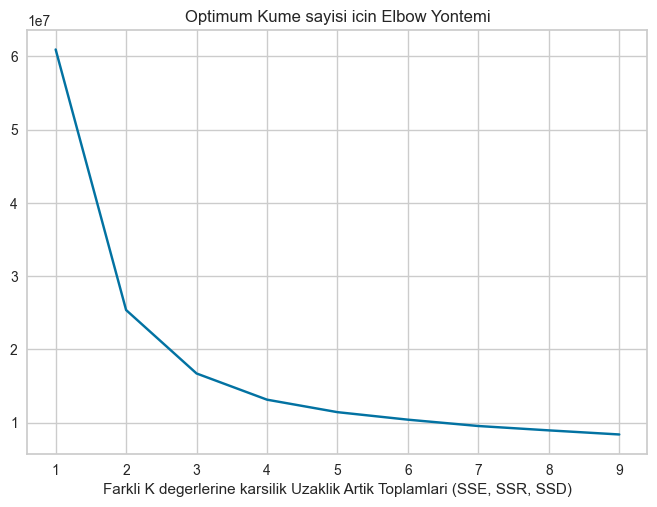

In [217]:
plt.plot(K, ssd, 'bx-')
plt.xlabel('Farkli K degerlerine karsilik Uzaklik Artik Toplamlari (SSE, SSR, SSD)')
plt.title('Optimum Kume sayisi icin Elbow Yontemi')
plt.show()

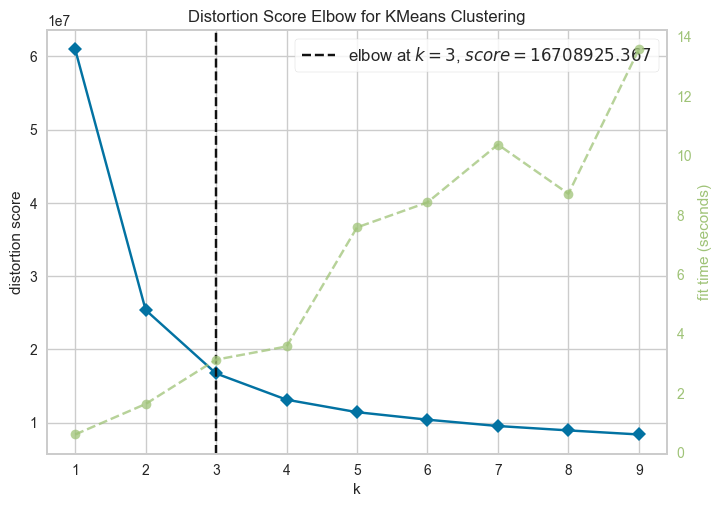

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [218]:
kmenas = KMeans()
elbow = KElbowVisualizer(kmeans, k=(1, 10))
elbow.fit(df_clus)
elbow.show()

### K-MEANS

In [271]:
kmeans = KMeans(n_clusters=3, n_init=10).fit(df_clus)

In [272]:
k_means_clusters = kmeans.labels_

In [273]:
df_04['k_means_cluster_no'] = k_means_clusters

In [274]:
df_04['k_means_cluster_no'] = df_04['k_means_cluster_no'] + 1

In [275]:
df_04 = one_hot_encoder(df_04, ['k_means_cluster_no'])

In [276]:
clus_col = [col for col in df_04.columns if 'k_means' in col]

In [277]:
df_04 = true_false_to_binary(df_04, clus_col)

In [278]:
df_04.head()

,MONTH,N_SECONDS_1,N_SECONDS_2,N_SECONDS_3,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,FEATURE_12,FEATURE_13,FEATURE_14,FEATURE_15,FEATURE_16,FEATURE_17,FEATURE_18,FEATURE_19,FEATURE_20,FEATURE_21,FEATURE_22,FEATURE_23,FEATURE_24,FEATURE_25,FEATURE_26,FEATURE_27,FEATURE_28,FEATURE_29,FEATURE_30,FEATURE_31,FEATURE_32,FEATURE_33,FEATURE_34,FEATURE_35,FEATURE_36,FEATURE_37,FEATURE_38,FEATURE_39,FEATURE_40,FEATURE_41,FEATURE_42,FEATURE_43,FEATURE_44,FEATURE_45,FEATURE_46,FEATURE_47,FEATURE_48,FEATURE_49,ID_FREQ,FEATURE-48+49,MENU1,MENU2,MENU3,MENU4,MENU5,MENU6,MENU7,MENU8,MENU9,NEW_TUFE,NEW_DVCE_PRICE_CAT,FEATURE_48_CUT,FEATURE_49_CUT,CARRIER_KKTCELL,CARRIER_RARE,CARRIER_TEKNOSA,CARRIER_TURK TELEKOM,CARRIER_TURKCELL,CARRIER_UNKNOWN,CARRIER_VODAFONE,DEVICEBRAND_GM,DEVICEBRAND_HUAWEI,DEVICEBRAND_OPPO,DEVICEBRAND_POCO,DEVICEBRAND_RARE,DEVICEBRAND_REALME,DEVICEBRAND_REDMI,DEVICEBRAND_SAMSUNG,NEW_FEATURE_48_TUFE_0-2.880,NEW_FEATURE_48_TUFE_0-3.540,NEW_FEATURE_48_TUFE_1-1.880,NEW_FEATURE_48_TUFE_1-2.880,NEW_FEATURE_48_TUFE_1-3.540,NEW_FEATURE_48_TUFE_2-1.880,NEW_FEATURE_48_TUFE_2-2.880,NEW_FEATURE_48_TUFE_2-3.540,NEW_FEATURE_48_TUFE_3-1.880,NEW_FEATURE_48_TUFE_3-2.880,NEW_FEATURE_48_TUFE_3-3.540,NEW_FEATURE_48_TUFE_4-1.880,NEW_FEATURE_48_TUFE_4-2.880,NEW_FEATURE_48_TUFE_4-3.540,NEW_FEATURE_49_TUFE_0-2.880,NEW_FEATURE_49_TUFE_0-3.540,NEW_FEATURE_49_TUFE_1-1.880,NEW_FEATURE_49_TUFE_1-2.880,NEW_FEATURE_49_TUFE_1-3.540,NEW_FEATURE_49_TUFE_2-1.880,NEW_FEATURE_49_TUFE_2-2.880,NEW_FEATURE_49_TUFE_2-3.540,NEW_FEATURE_49_TUFE_3-1.880,NEW_FEATURE_49_TUFE_3-2.880,NEW_FEATURE_49_TUFE_3-3.540,NEW_FEATURE_49_TUFE_4-1.880,NEW_FEATURE_49_TUFE_4-2.880,NEW_FEATURE_49_TUFE_4-3.540,NEW_FEATURE_49_TUFE_5-1.880,NEW_FEATURE_49_TUFE_5-2.880,NEW_FEATURE_49_TUFE_5-3.540,k_means_cluster_no_2,k_means_cluster_no_3
0,10,8.565,6.889,5.328,-1.198,1.113,-1.123,-0.264,2.161,2.651,0.810,1.516,2.351,-4.608,0.678,-0.555,3.502,-0.765,1.543,-1.458,-1.017,-1.820,0.726,-1.444,1.087,2.102,-0.249,-0.583,-1.330,1.407,1.054,-1.532,1.667,0.251,-0.091,2.676,-0.621,0.163,1.720,-6.139,-0.303,2.784,-3.135,-3.794,0.930,-2.613,-2.033,2.646,-1.023,1.659,-1.559,-2.161,30,58,1,88,0,1,0,1,1,0,0,0,0,3,4,2,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,10,8.554,6.324,6.189,-2.336,2.568,-0.495,0.949,3.568,3.358,0.434,0.886,1.452,-3.184,1.024,1.166,2.916,-1.281,3.019,-3.163,-1.120,-2.798,0.287,-2.029,0.260,0.962,-0.534,-1.311,-0.144,-1.562,1.931,-0.942,-0.000,-1.372,1.225,2.795,-0.961,0.114,1.048,-5.697,0.902,-0.073,-2.366,-0.600,0.815,-0.984,-1.454,-0.022,-0.196,2.776,-0.319,-4.291,21,45,1,66,0,0,0,1,0,0,1,1,0,3,3,2,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,10,8.252,8.094,3.780,-2.561,2.062,-0.185,1.062,4.198,1.551,-0.596,-0.619,2.017,-4.631,-0.663,-0.838,1.821,-2.171,3.695,-0.922,-2.873,-2.042,0.533,-0.128,0.450,2.716,-0.178,0.052,-0.518,-0.043,1.157,-0.527,-0.088,-0.497,1.203,2.742,-0.623,1.757,2.059,-5.359,0.929,1.133,-3.100,-1.253,1.057,-1.669,-3.599,1.674,0.632,1.293,-2.231,-2.384,19,61,2,80,0,1,0,1,0,0,0,1,0,3,2,1,4,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,10,8.170,5.040,4.170,-2.530,3.358,-0.851,1.644,2.849,3.887,1.855,0.988,2.066,-5.804,1.931,0.151,3.145,-2.673,0.378,-2.657,-0.378,-3.276,0.003,-0.674,-0.227,1.817,0.068,-0.787,-1.708,-2.000,1.770,0.049,0.230,-0.304,1.659,1.692,-1.105,1.242,2.043,-3.854,0.649,0.944,-3.027,-1.824,0.204,-1.861,-1.220,1.863,0.213,1.030,-1.142,-4.466,2,41,1,43,1,1,0,0,0,1,0,0,0,3,3,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,10,8.115,6.669,6.572,-2.922,2.096,0.061,-1.488,3.225,2.092,-0.993,0.686,2.090,-2.974,-0.797,-1.459,2.398,-1.308,3.381,-2.664,-2.219,-1.714,1.288,-2.250,2.345,0.403,-0.077,0.289,1.847,1.424,1.888,-1.022,1.021,-0.843,-0.859,2.565,0.412,0.068,

# MODEL

# CATBOOST MODEL

In [310]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from catboost import Pool
import joblib
from sklearn.metrics import make_scorer, jaccard_score

In [284]:
df_02 = df_04.copy()

In [285]:
y = df_02[['MENU1', 'MENU2','MENU3','MENU4','MENU5','MENU6','MENU7','MENU8','MENU9']]
X = df_02.drop(['MENU1', 'MENU2','MENU3','MENU4','MENU5','MENU6','MENU7','MENU8','MENU9'], axis=1)

In [286]:
#3-fold cross-validation using StratifiedKFold
cv = MultilabelStratifiedKFold(n_splits=3, shuffle=True, random_state=17)

In [287]:
# We created an empty DataFrame
all_feature_importances = pd.DataFrame()

# We created an empty list
all_jaccard_scores = []

# We cross-validated each floor
for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    # Veriyi böl
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # We defined and trained the model
    catboost_model = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, loss_function='MultiLogloss', verbose=0)
    catboost_model.fit(X_train, y_train)

    # We created the Pool object
    train_pool = Pool(X_train, y_train)

    # We took Feature importance and added it to DataFrame
    feature_importances = pd.DataFrame({'Feature': X_train.columns, f'Fold_{i+1}_Importance': catboost_model.feature_importances_})
    if all_feature_importances.empty:
        all_feature_importances = feature_importances
    else:
        all_feature_importances = pd.merge(all_feature_importances, feature_importances, on='Feature')

    # We calculated the Jaccard score
    y_pred_prob = catboost_model.predict_proba(X_test)
    top3_indices = np.argsort(y_pred_prob, axis=1)[:, -3:]
    new_y_pred = np.zeros_like(y_pred_prob)
    for j, indices in enumerate(top3_indices):
        new_y_pred[j, indices] = 1
    jaccard = jaccard_score(y_test, new_y_pred, average='micro')
    all_jaccard_scores.append(jaccard)

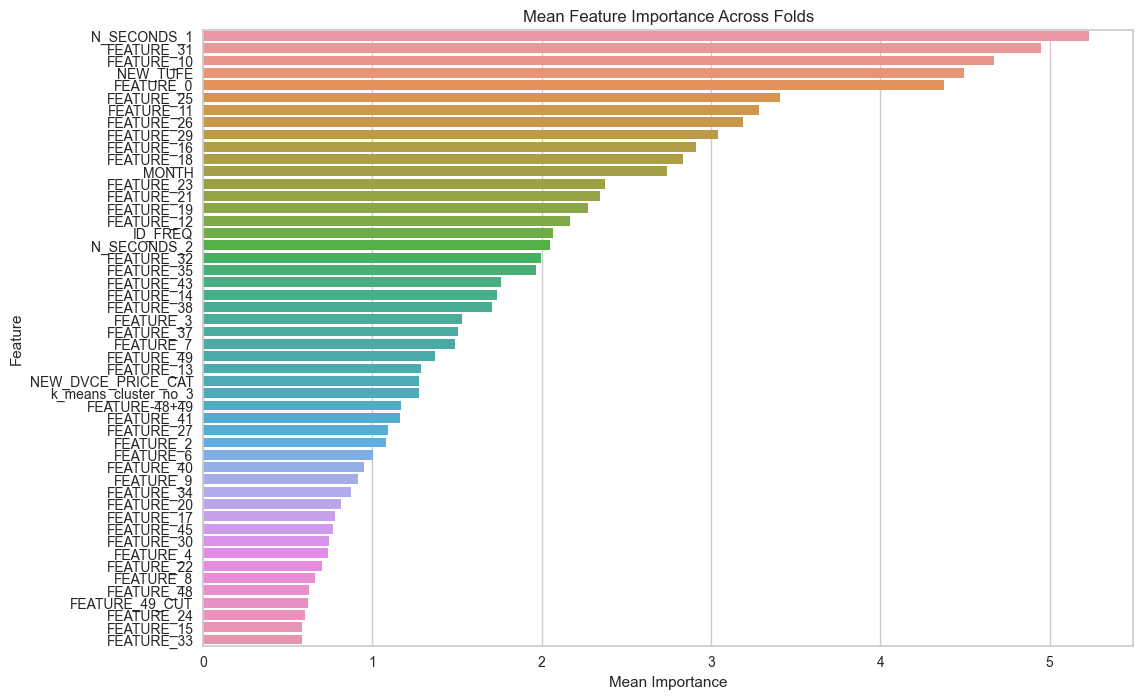

Jaccard Skorları: [0.5080005140892587, 0.5082744209506577, 0.5105723689491852]
Ortalama Jaccard Skoru: 0.5089491013297005


In [289]:
# Average feature importance of all layers
all_feature_importances['Mean_Importance'] = all_feature_importances.iloc[:, 1:].mean(axis=1)

# We listed the feature importance
all_feature_importances = all_feature_importances.sort_values(by='Mean_Importance', ascending=False)

# Graphic
plt.figure(figsize=(12, 8))
sns.barplot(x='Mean_Importance', y='Feature', data=all_feature_importances.head(50))
plt.title('Mean Feature Importance Across Folds')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.show()

# Jaccard scores
print("Jaccard Skorları:", all_jaccard_scores)
print("Ortalama Jaccard Skoru:", np.mean(all_jaccard_scores))

In [290]:
def hist_graph(pred, test):
    num_targets = pred.shape[1]
    num_groups = num_targets // 3  # Number of groups containing 3 target variables
    
    fig, axs = plt.subplots(2 * num_groups, 3, figsize=(75, 70))
    
    for g in range(num_groups):
        for i in range(3):
            pred_idx = g * 3 + i
            axs[g * 2, i].hist(pred[:, pred_idx], color='blue', histtype='barstacked', alpha=0.5, edgecolor='grey')
            axs[g * 2, i].axvline(pred[:, pred_idx].mean(), color='red', linestyle='dashed', linewidth=10)
            axs[g * 2, i].axvline(pred[:, pred_idx].std(), color='black', linestyle='dashdot', linewidth=10)
            axs[g * 2, i].set_xlabel(f"Pred {pred_idx}", fontsize=60)
            axs[g * 2, i].set_ylabel('Deger', fontsize=60)
            axs[g * 2, i].set_title(f"Pred {pred_idx} Histogram Grafigi", fontsize=75)
            axs[g * 2, i].legend(handles=[mpatches.Patch(color='red', label='Mean'),
                                          mpatches.Patch(color='black', label='Std')], fontsize=50)
            
            test_idx = g * 3 + i
            axs[g * 2 + 1, i].hist(test.iloc[:, test_idx], color='green', histtype='barstacked', alpha=0.5, edgecolor='grey')
            axs[g * 2 + 1, i].axvline(test.iloc[:, test_idx].mean(), color='red', linestyle='dashed', linewidth=10)
            axs[g * 2 + 1, i].axvline(test.iloc[:, test_idx].std(), color='black', linestyle='dashdot', linewidth=10)
            axs[g * 2 + 1, i].set_xlabel(f"Test {test_idx}", fontsize=60)
            axs[g * 2 + 1, i].set_ylabel('Deger', fontsize=60) 
            axs[g * 2 + 1, i].set_title(f"Test {test_idx} Histogram Grafigi", fontsize=75) 
            axs[g * 2 + 1, i].legend(handles=[mpatches.Patch(color='red', label='Mean'),
                                              mpatches.Patch(color='black', label='Std')], fontsize=50)  
    
    plt.tight_layout()
    plt.show()

In [291]:
hist_graph(new_y_pred, y_test)

In [292]:
cm_decision_base = multilabel_confusion_matrix(y_test, new_y_pred)

In [293]:
for i in range(len(cm_decision_base)):
    print(f"Class {i + 1}:\n", cm_decision_base[i])

Class 1:
 [[23101   810]
 [ 6776   675]]
Class 2:
 [[    2  6519]
 [    3 24838]]
Class 3:
 [[29479     0]
 [ 1883     0]]
Class 4:
 [[9970 8452]
 [3925 9015]]
Class 5:
 [[24010  1051]
 [ 4892  1409]]
Class 6:
 [[   48  9648]
 [   34 21632]]
Class 7:
 [[29985     0]
 [ 1377     0]]
Class 8:
 [[17823  3721]
 [ 4024  5794]]
Class 9:
 [[23270   283]
 [ 7570   239]]


### Catboost Hyperparameters

In [ ]:
?CatBoostClassifier

In [241]:
catboost_params = {'iterations': [1000, 1500, 2000],
                   'learning_rate': [0.01, 0.05, 0.01],
                   'depth': [5, 7, 9],
                   'grow_policy': ["SymmetricTree"],
                   'early_stopping_rounds': [100, 200]}

In [294]:
cv_1 = MultilabelStratifiedKFold(n_splits=10, shuffle=True, random_state=17)

In [243]:
jaccard_scorer = make_scorer(jaccard_score, average='micro')

In [ ]:
catboost_best_grid = RandomizedSearchCV(catboost_model, catboost_params, cv=cv_1, n_jobs=-1, verbose=True, scoring=jaccard_scorer).fit(X, y)

In [295]:
# Created 10-fold cross-validation using StratifiedKFold
cv_10 = MultilabelStratifiedKFold(n_splits=10, shuffle=True, random_state=17)


all_feature_importances = pd.DataFrame()


all_jaccard_scores = []


for i, (train_idx, test_idx) in enumerate(cv_10.split(X, y)):
    # Veriyi böl
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    
    catboost_model = CatBoostClassifier(iterations=1500, 
                                        depth=6, 
                                        learning_rate=0.1, 
                                        grow_policy='SymmetricTree', 
                                        early_stopping_rounds=200, 
                                        loss_function='MultiLogloss', 
                                        verbose=0)
    
    catboost_model.fit(X_train, y_train)

    
    train_pool = Pool(X_train, y_train)

    
    feature_importances = pd.DataFrame({'Feature': X_train.columns, f'Fold_{i+1}_Importance': catboost_model.feature_importances_})
    if all_feature_importances.empty:
        all_feature_importances = feature_importances
    else:
        all_feature_importances = pd.merge(all_feature_importances, feature_importances, on='Feature')

    
    y_pred_prob = catboost_model.predict_proba(X_test)
    top3_indices = np.argsort(y_pred_prob, axis=1)[:, -3:]
    new_y_pred = np.zeros_like(y_pred_prob)
    for j, indices in enumerate(top3_indices):
        new_y_pred[j, indices] = 1
    jaccard = jaccard_score(y_test, new_y_pred, average='micro')
    all_jaccard_scores.append(jaccard)

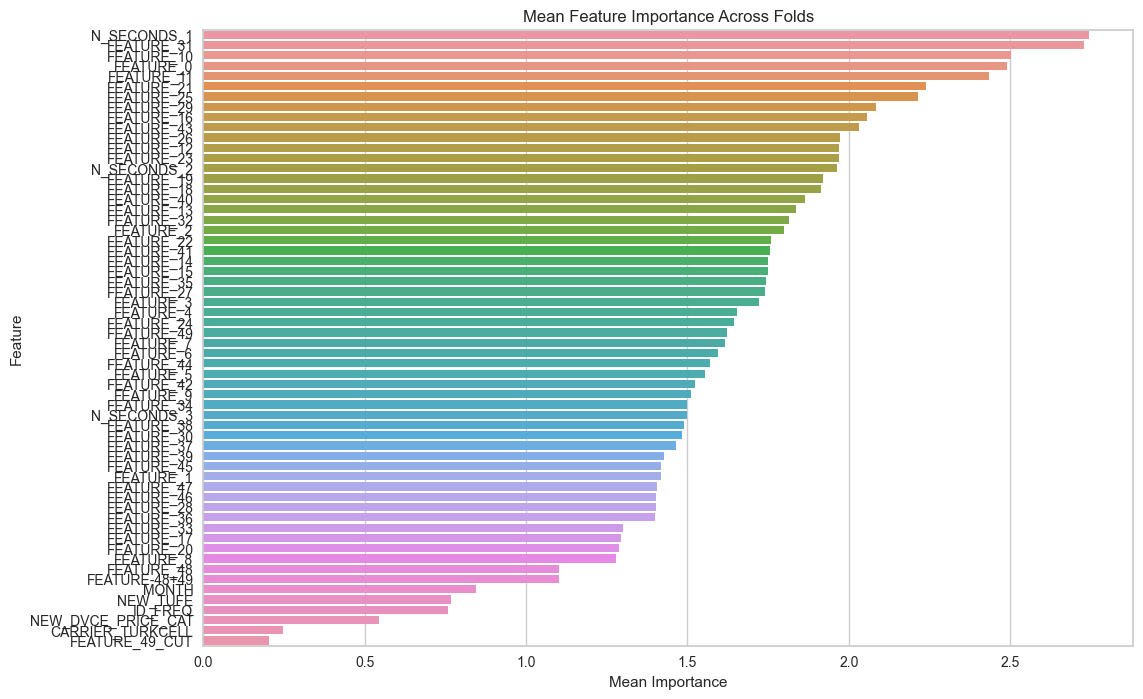

Jaccard Skorları: [0.5120446689710183, 0.5165721351576571, 0.5171820381823071, 0.5153028350515464, 0.5139261063743402, 0.5107982979634437, 0.5180180180180181, 0.5143600332519911, 0.5141635057703172, 0.5145052111314065]
Ortalama Jaccard Skoru: 0.5146872849872045


In [298]:
all_feature_importances['Mean_Importance'] = all_feature_importances.iloc[:, 1:].mean(axis=1)


all_feature_importances = all_feature_importances.sort_values(by='Mean_Importance', ascending=False)


plt.figure(figsize=(12, 8))
sns.barplot(x='Mean_Importance', y='Feature', data=all_feature_importances.head(60))
plt.title('Mean Feature Importance Across Folds')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.show()


print("Jaccard Skorları:", all_jaccard_scores)
print("Ortalama Jaccard Skoru:", np.mean(all_jaccard_scores))

In [299]:
hist_graph(new_y_pred, y_test)

In [300]:
cm_decision_10 = multilabel_confusion_matrix(y_test, new_y_pred)

In [301]:
for i in range(len(cm_decision_10)):
    print(f"Class {i + 1}:\n", cm_decision_10[i])

Class 1:
 [[6749  412]
 [1911  325]]
Class 2:
 [[  20 1916]
 [  16 7445]]
Class 3:
 [[8829    3]
 [ 564    1]]
Class 4:
 [[3375 2140]
 [1404 2478]]
Class 5:
 [[6991  516]
 [1309  581]]
Class 6:
 [[ 216 2714]
 [ 164 6303]]
Class 7:
 [[8983    1]
 [ 412    1]]
Class 8:
 [[5473  990]
 [1142 1792]]
Class 9:
 [[6709  345]
 [2115  228]]


In [307]:
model_filename = 'catboost_model.joblib'
joblib.dump(catboost_model, model_filename)

['catboost_model.joblib']